In [1]:
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import jaccard_score
from matplotlib.colors import ListedColormap
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
from rdkit.Chem.Scaffolds.MurckoScaffold import MakeScaffoldGeneric

import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
from scripts import visualization
import importlib as imp
imp.reload(visualization)
import numpy as np
from rdkit.Chem import PandasTools



In [7]:
def KL_divergence_prep(df1, df2, smiles1, smiles2):
    """
    Prepare data and compute similarity metrics between two sets for KL divergence.

    Args:
        df1 (pd.DataFrame): First DataFrame containing data.
        df2 (pd.DataFrame): Second DataFrame containing data.
        smiles1 (str): Column name for SMILES in df1.
        smiles2 (str): Column name for SMILES in df2.

    Returns:
        list: List of highest Tanimoto coefficients between the two sets.
    """
    highest_TC, avg_TC = [], []

    # Generate Morgan fingerprints for compounds in df1 and df2
    fps1 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 3, nBits=2048) for x in df1[smiles1].tolist()]
    fps2 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 3, nBits=2048) for x in df2[smiles2].tolist()]
    
    # Calculate Tanimoto coefficients between compounds in df1 and df2
    count_recall_set = -1
    array_for_inex_for_recall_set = []
    aray_for_smiles = []
    arr = pd.DataFrame(columns = ['recall_id', 'recall_set'])
    for fps in fps1:
        count_recall_set += 1
        total_compared, total_tca, tc, tca = 0, 0, 0, 0
        for fps_inp in fps2:
            total_compared += 1
            tca = DataStructs.FingerprintSimilarity(fps, fps_inp)
            total_tca += tca
            if tca > tc:
                tc = tca
            if tc == 1:
                if count_recall_set not in array_for_inex_for_recall_set:
                    if df1[smiles1][count_recall_set] not in aray_for_smiles:
                        index = df1[df1[smiles1] == df1[smiles1][count_recall_set]].index.tolist()
                        for x in index:
                            array_for_inex_for_recall_set.append(x)
                        aray_for_smiles.append(df1[smiles1][count_recall_set])
                        arr.loc[-1] = [index, df1[smiles1][count_recall_set]]
                        arr.index = arr.index + 1
                        arr = arr.sort_index()                       
                        

        highest_TC.append(tc)
        avg_TC.append(float(total_tca / total_compared))
        
    PandasTools.AddMoleculeColumnToFrame(arr,smilesCol='recall_set')
    
    ar = []
    for x in range(len(arr)):
        smiles_recall = arr['recall_set'][x]
        index = df2[df2[smiles2] == smiles_recall].index.tolist()
        ar.append(index)
    arr['output_id'] = ar
    display(arr)
    print("Array with index in recall_set with 100% similarity: ", array_for_inex_for_recall_set)
    # Print some statistics
    #print("I>0.7 ", [i for i in highest_TC if i > 0.7])
    print("How much TC = 1: ", str(sum(i == 1 for i in highest_TC)))
    #print(np.asarray(highest_TC).mean())
    #print(highest_TC)

    return highest_TC

In [13]:
def KL_divergence_prep_1(df1, df2, smiles1, smiles2):
    """
    Prepare data and compute similarity metrics between two sets for KL divergence.

    Args:
        df1 (pd.DataFrame): First DataFrame containing data.
        df2 (pd.DataFrame): Second DataFrame containing data.
        smiles1 (str): Column name for SMILES in df1.
        smiles2 (str): Column name for SMILES in df2.

    Returns:
        list: List of highest Tanimoto coefficients between the two sets.
    """
    highest_TC, avg_TC = [], []

    # Generate Morgan fingerprints for compounds in df1 and df2
    fps1 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 3, nBits=2048) for x in df1[smiles1].tolist()]
    fps2 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 3, nBits=2048) for x in df2[smiles2].tolist()]

    df1['fps'] = fps1
    df2['fps'] = fps2
    # Calculate Tanimoto coefficients between compounds in df1 and df2
    array_index_recall_set = []
    array_index_output_set = []
    array_for_smiles_recall = []
    array_for_smiles_output = []
    
    arr = pd.DataFrame(columns = ['recall_id', 'output_id','tc','recall_set', 'output_set'])
    print("Delka recall setu: ", len(df1))
    for x in range(len(df1)):
        print("X: ", x)
        fps = df1.loc[x]['fps']
        total_compared, total_tca, tc, tca = 0, 0, 0, 0
        for y in range(len(df2)):
            fps_inp = df2.loc[y]['fps']
            total_compared += 1
            tca = DataStructs.FingerprintSimilarity(fps, fps_inp)
            total_tca += tca
            if tca > tc:
                tc = tca
                if tc == 1:
                    if x not in array_index_recall_set or y not in array_index_output_set:
                        if df1[smiles1][x] not in array_for_smiles_recall or df2[smiles2][y] not in array_for_smiles_output:
                            index_recall = df1[df1[smiles1] == df1[smiles1][x]].index.tolist()
                            index_output = df2[df2[smiles2] == df2[smiles2][y]].index.tolist()
                            for z in index_recall:
                                array_index_recall_set.append(z)
                            for t in index_output:
                                array_index_output_set.append(t)
                            arr.loc[-1] = [index_recall,index_output,tc,df1[smiles1][x], df2[smiles2][y]]
                            arr.index = arr.index + 1
                            arr = arr.sort_index()    
                        

        highest_TC.append(tc)
        avg_TC.append(float(total_tca / total_compared))
        
    PandasTools.AddMoleculeColumnToFrame(arr,smilesCol='recall_set', molCol = 'recall_compound')
    PandasTools.AddMoleculeColumnToFrame(arr,smilesCol='output_set', molCol = 'output_compound')
    display(arr)

    
    #print("Array with index in recall_set with 100% similarity: ", array_for_inex_for_recall_set)
    # Print some statistics
    #print("I>0.7 ", [i for i in highest_TC if i > 0.7])
    print("How much TC = 1: ", str(sum(i == 1 for i in highest_TC)))
    #print(np.asarray(highest_TC).mean())
    #print(highest_TC)

    return highest_TC, arr

In [14]:
def KL_histograms(data1, data2):

    
    # Plot the histograms
    plt.hist(data1, bins=100, range=[0.0, 1.0], alpha=0.5, color='blue', label='Molpher library')
    plt.hist(data2, bins=100, range=[0.0, 1.0], alpha=0.5, color='orange', label='DrugEx library')

    # Calculate and plot vertical lines for the average values
    plt.axvline(np.asarray(data1).mean(), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.asarray(data2).mean(), color='orange', linestyle='dashed', linewidth=1)

    plt.xlabel('Highest Tc', fontsize = 18)
    plt.ylabel('Frequency' , fontsize = 18)
    plt.title('Recall Set vs. Molpher and DrugEx', fontsize = 20)
    plt.grid(True)
    plt.legend()
    return plt
    #plt.show()

In [101]:
def KL_histograms_more(ax, data1, data2):

    # Plot the histograms
    ax.hist(data1, bins=100, range=[0.0, 1.0], alpha=0.5, color='blue', label='Molpher library dis 0')
    ax.hist(data2, bins=100, range=[0.0, 1.0], alpha=0.5, color='orange', label='DrugEx library dis 0')

    # Calculate and plot vertical lines for the average values
    ax.axvline(np.asarray(data1).mean(), color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(np.asarray(data2).mean(), color='orange', linestyle='dashed', linewidth=1)

    ax.set_xlabel('Highest Tc', fontsize = 18)
    ax.set_ylabel('Frequency' , fontsize = 18)

    ax.grid(True)
    ax.legend()


In [2]:
def KL_histograms_for_all_10(rows, data, text):

    fig, ax = plt.subplots(nrows=rows, ncols=2, figsize=(20, 22), sharex=True)  

    number = 0
    number_sim = 0
    for row in range(rows):
    # Plot the histograms
        for column in range(2):
            if number < 5:
                print(number)
                data1 = f"generator_1_dis_{number}"
                data2 = f"generator_2_dis_{number}"

                ax[row,column].hist(data[data1], bins=100, range=[0.0, 1.0], alpha=0.5, color='blue', label=f'Molpher library dis {number}')
                ax[row,column].hist(data[data2], bins=100, range=[0.0, 1.0], alpha=0.5, color='orange', label=f'DrugEx library dis {number}')
            
                # Calculate and plot vertical lines for the average values
                ax[row,column].axvline(np.asarray(data[data1]).mean(), color='blue', linestyle='dashed', linewidth=1)
                ax[row,column].axvline(np.asarray(data[data2]).mean(), color='orange', linestyle='dashed', linewidth=1)
            
                ax[row,column].set_xlabel('Highest Tc', fontsize = 18)
                ax[row,column].set_ylabel('Frequency' , fontsize = 18)
            
                ax[row,column].grid(True)
                ax[row,column].legend()
                number += 1
            else:
                print(number)
                data1 = f"generator_1_sim_{number_sim}"
                data2 = f"generator_2_sim_{number_sim}"
                number_sim += 1
           
                ax[row,column].hist(data[data1], bins=100, range=[0.0, 1.0], alpha=0.5, color='blue', label=f'Molpher library sim {number_sim}')
                ax[row,column].hist(data[data2], bins=100, range=[0.0, 1.0], alpha=0.5, color='orange', label=f'DrugEx library sim {number_sim}')
            
                # Calculate and plot vertical lines for the average values
                ax[row,column].axvline(np.asarray(data[data1]).mean(), color='blue', linestyle='dashed', linewidth=1)
                ax[row,column].axvline(np.asarray(data[data2]).mean(), color='orange', linestyle='dashed', linewidth=1)
            
                ax[row,column].set_xlabel('Highest Tc', fontsize = 18)
                ax[row,column].set_ylabel('Frequency' , fontsize = 18)
            
                ax[row,column].grid(True)
                ax[row,column].legend()
                number += 1
       

    fig.suptitle(text, fontsize = 20)
    plt.savefig("data/results/Glucocorticoid_receptor/csk_scaffolds/KL_divergence_Recall_set_vs_Molpher_DrugEx_compounds.png") 
    plt.show()



----------------------------------------------------------------------------------------------------------------
Molpher dis 0


----------------------------------------------------------------------------------------------------------------


DrugEx dis 0


recall_id  output_id   tc  \
0                                         [159, 160]      [140]  1.0   
1                     [122, 123, 124, 125, 126, 127]  [91, 141]  1.0   
2  [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...      [155]  1.0   

                               recall_set  \
0              C1CCC(CCCC2CCC3CCCC3C2)CC1   
1  C1CCC(CCCC2CCC3C2CCC2C4CCCCC4CCC32)CC1   
2             C1CCC2C(C1)CCC1C3CCCC3CCC21   

                               output_set  \
0              C1CCC(CCCC2CCC3CCCC3C2)CC1   
1  C1CCC(CCCC2CCC3C2CCC2C4CCCCC4CCC32)CC1   
2             C1CCC2C(C1)CCC1C3CCCC3CCC21   

                                    recall_scaffold  \
0  <rdkit.Chem.rdchem.Mol object at 0x7f891d2bbc80>   
1  <rdkit.Chem.rdchem.Mol object at 0x7f891d2bb970>   
2  <rdkit.Chem.rdchem.Mol object at 0x7f891d2bbf90>   

                                    output_scaffold  
0  <rdkit.Chem.rdchem.Mol object at 0x7f891d2bbf20>  
1  <rdkit.Chem.rdchem.Mol object at 0x7f891d2bbeb0>  
2  <rdkit.Chem.rdchem.Mol object at 0x7f891d2bbe40>
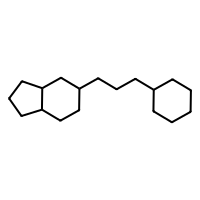
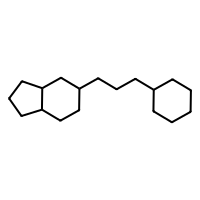
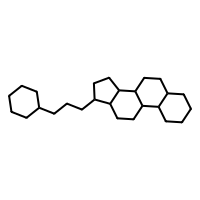
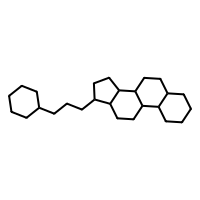
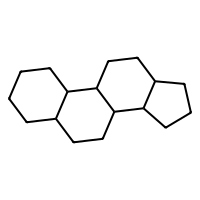
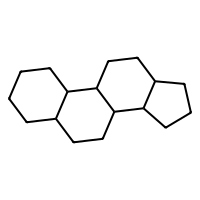

How much TC = 1:  47


NameError: name 'high_TC_recall_set_Molpher' is not defined

In [22]:
#scafold_for_quick_calculation
data = {}
for type in ['dis','sim']:
    for num in range(5):
        molpher_set = pd.read_csv(f"data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/Molpher/scaffolds_of_output_set_cluster_{num}_{type}_Molpher.csv", header=None)
        molpher_set.columns = ['virtual_compounds_smiles']
        molpher_set = molpher_set[:300]
        
        drugex_set = pd.read_csv(f"data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/DrugEx/scaffolds_of_output_set_cluster_{num}_{type}_DrugEx.csv", header=None)
        drugex_set.columns = ['virtual_compounds_smiles']
        drugex_set = drugex_set[:300]

        recall_set = pd.read_csv(f"data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/Molpher/scaffolds_of_recall_set_cluster_{num}_{type}_Molpher.csv", header=None)
        recall_set.columns = ['canonical_smiles']
        print("\n")
        print("----------------------------------------------------------------------------------------------------------------")
        print(f"Molpher {type} {num}")
        #high_TC_recall_set_Molpher= KL_divergence_prep_1(recall_set, molpher_set, 'canonical_smiles', 'virtual_compounds_smiles')
        print("\n")
        print("----------------------------------------------------------------------------------------------------------------")
        print("\n")
        print(f"DrugEx {type} {num}")
        high_TC_recall_set_DrugEx = KL_divergence_prep_1(recall_set, drugex_set, 'canonical_smiles', 'virtual_compounds_smiles')


        data[f'generator_1_{type}_{num}'] = high_TC_recall_set_Molpher
        data[f'generator_2_{type}_{num}'] = high_TC_recall_set_DrugEx
#data 




----------------------------------------------------------------------------------------------------------------
Molpher sim 0
Delka recall setu:  616
X:  0
X:  1
X:  2
X:  3
X:  4
X:  5
X:  6
X:  7
X:  8
X:  9
X:  10
X:  11
X:  12
X:  13
X:  14
X:  15
X:  16
X:  17
X:  18
X:  19
X:  20
X:  21
X:  22
X:  23
X:  24
X:  25
X:  26
X:  27
X:  28
X:  29
X:  30
X:  31
X:  32
X:  33
X:  34
X:  35
X:  36
X:  37
X:  38
X:  39
X:  40
X:  41
X:  42
X:  43
X:  44
X:  45
X:  46
X:  47
X:  48
X:  49
X:  50
X:  51
X:  52
X:  53
X:  54
X:  55
X:  56
X:  57
X:  58
X:  59
X:  60
X:  61
X:  62
X:  63
X:  64
X:  65
X:  66
X:  67
X:  68
X:  69
X:  70
X:  71
X:  72
X:  73
X:  74
X:  75
X:  76
X:  77
X:  78
X:  79
X:  80
X:  81
X:  82
X:  83
X:  84
X:  85
X:  86
X:  87
X:  88
X:  89
X:  90
X:  91
X:  92
X:  93
X:  94
X:  95
X:  96
X:  97
X:  98
X:  99
X:  100
X:  101
X:  102
X:  103
X:  104
X:  105
X:  106
X:  107
X:  108
X:  109
X:  110
X:  111
X:  112
X:  113
X:  114
X:  115
X:  116
X:  117
X:  118
X:  1

recall_id                                          output_id   tc  \
0      [606]                                           [193042]  1.0   
1      [596]                                           [914218]  1.0   
2      [591]                         [513166, 1075205, 1076093]  1.0   
3      [587]                                           [194844]  1.0   
4      [578]                                           [879258]  1.0   
5      [569]                          [917008, 981513, 1029996]  1.0   
6      [553]                                          [1018332]  1.0   
7      [549]                                           [879258]  1.0   
8      [544]                                   [288189, 996388]  1.0   
9      [538]                                          [1018331]  1.0   
10     [537]                                           [879258]  1.0   
11     [534]                                   [875504, 982472]  1.0   
12     [520]                                           [862295]  1.0   
13     [519]                                          [1107093]  1.0   
14     [515]                                           [862295]  1.0   
15     [510]  [24042, 102257, 166143, 350649, 368447, 447162...  1.0   
16     [502]                                           [846404]  1.0   
17     [484]                                            [92965]  1.0   
18     [480]  [38834, 75557, 116677, 133731, 179057, 213116,...  1.0   
19     [479]  [213708, 249094, 328252, 328445, 348899, 40497...  1.0   
20     [478]                                           [310093]  1.0   
21     [475]                          [328531, 975073, 1087756]  1.0   
22     [472]                   [213276, 213707, 213866, 404976]  1.0   
23     [453]                                           [865600]  1.0   
24     [442]                           [634997, 635944, 637954]  1.0   
25     [392]                                           [264272]  1.0   
26     [390]  [264257, 266046, 462749, 566182, 691136, 72114...  1.0   
27     [382]  [264258, 462747, 480946, 566181, 583830, 72114...  1.0   
28     [380]  [480945, 583828, 737640, 742366, 821276, 87739...  1.0   
29     [325]                                           [857613]  1.0   
30     [312]                           [702679, 707245, 708647]  1.0   
31     [295]                                           [749693]  1.0   
32     [282]                                           [749693]  1.0   
33     [243]   [578537, 579992, 580272, 582897, 586367, 586676]  1.0   
34     [241]  [581465, 581627, 582564, 583934, 585780, 58594...  1.0   
35     [188]                                           [826176]  1.0   
36     [187]                                           [826176]  1.0   
37     [178]                                   [171530, 626498]  1.0   
38     [169]  [9547, 54793, 127520, 136814, 157473, 761164, ...  1.0   
39     [160]               [1081608, 1081739, 1085934, 1086613]  1.0   
40     [104]                                           [382424]  1.0   
41      [58]           [589096, 592076, 592159, 592373, 592490]  1.0   
42      [27]  [21924, 23075, 24664, 25171, 25905, 26565, 27307]  1.0   

                                           recall_set  \
0   Cc1cc(C)c(S(=O)(=O)N[C@@H](C)CNc2cc(C)cc3c2cnn...   
1   Cc1ccc(-n2ncc3c(NC[C@H](C)NS(=O)(=O)c4c(C)cc(C...   
2   Cc1cc(C)c(S(=O)(=O)N[C@@H](C)CNc2cc(C)cc3c2cnn...   
3   Cc1cc(C)c(S(=O)(=O)N[C@@H](C)CNc2cccc3c2cnn3-c...   
4   COc1ccc(F)cc1C(C)(C)C[C@](O)(Cc1cc2ccccc2[nH]1...   
5      CCC(O)(Cc1cc2ccncc2[nH]1)CC(C)(C)c1cc(F)ccc1OC   
6   Cc1cc2cc(CC(O)(CC(C)(C)c3cc(F)ccc3C)C(F)(F)F)[...   
7   COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2ccccc2[nH]1)C(...   
8   CCC(C)(C)C(O)(Cc1cc2ccncc2[nH]1)CC(C)(C)c1cc(F...   
9   Cc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2ccncc2[nH]1)C(F...   
10  COc1ccc(F)cc1C(C)(C)C[C@@](O)(Cc1cc2ccccc2[nH]...   
11  COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2ccncc2[nH]1)C(C)C   
12  COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2ccncc2[nH]1)C(...   
13  COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2
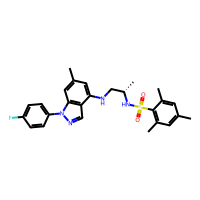
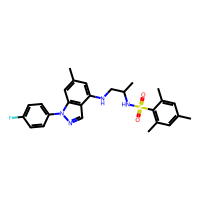
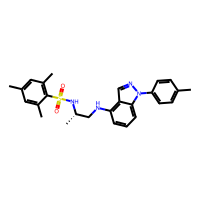
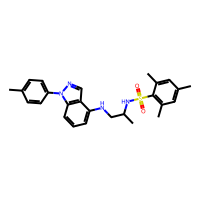
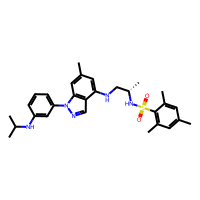
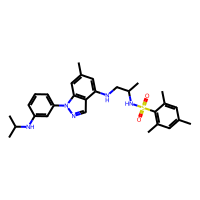
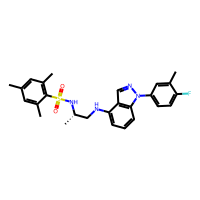
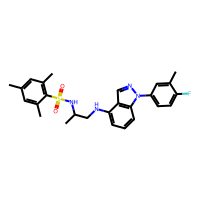
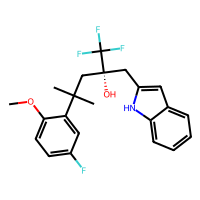
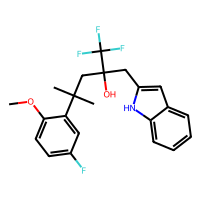
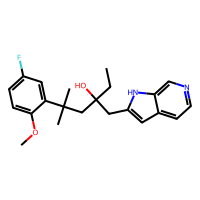
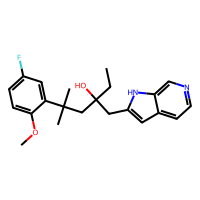
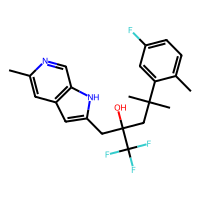
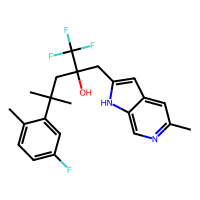
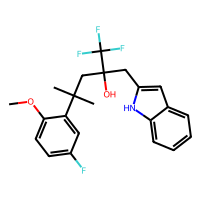
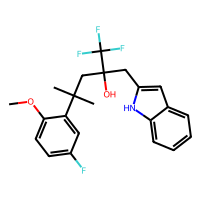
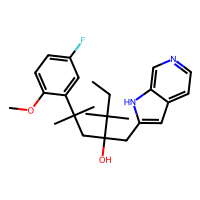
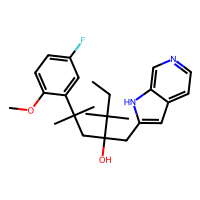
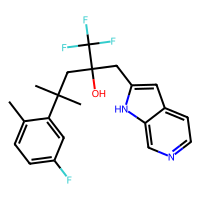
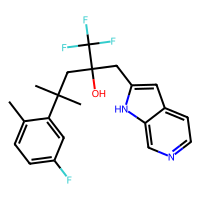
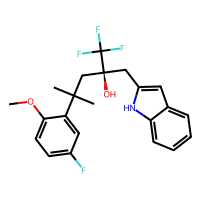
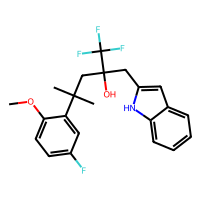
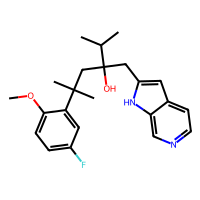
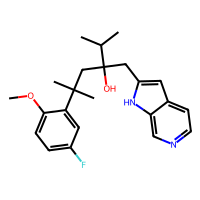
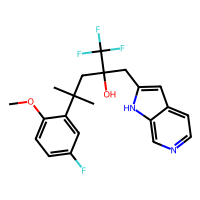
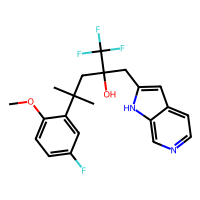
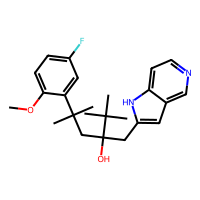
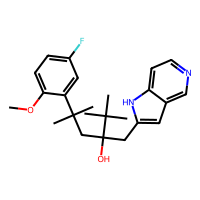
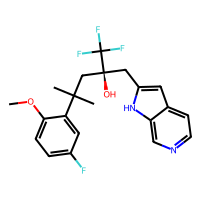
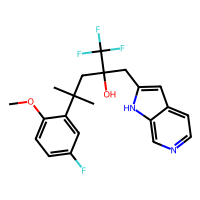
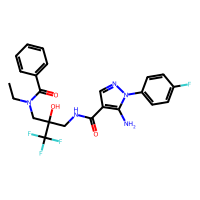
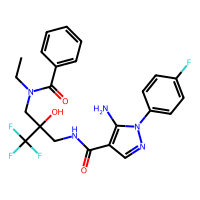
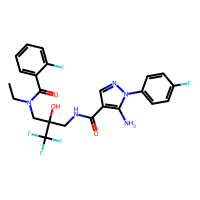
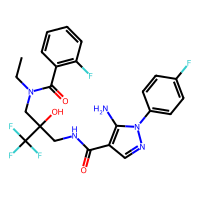
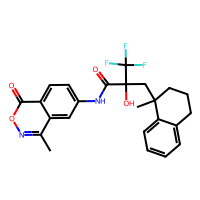
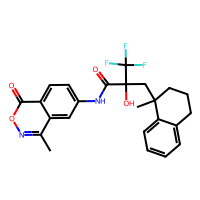
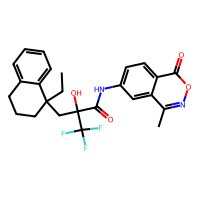
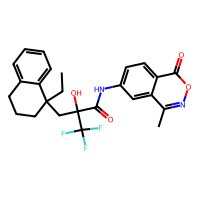
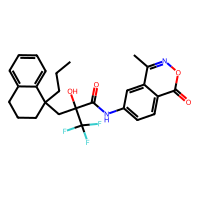
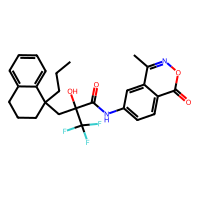
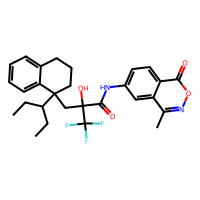
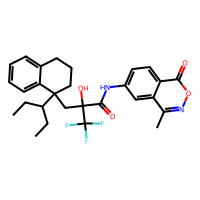
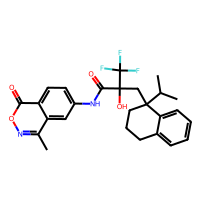
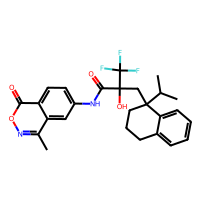
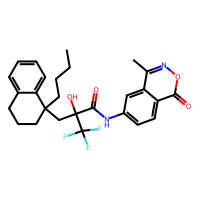
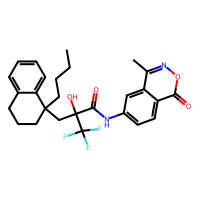
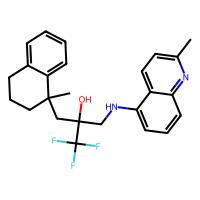
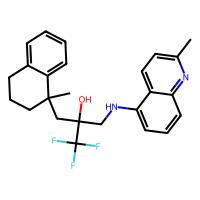
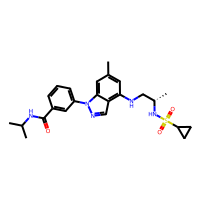
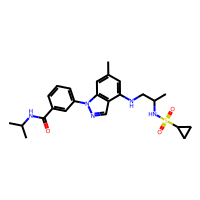
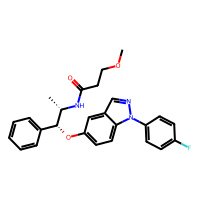
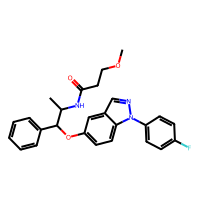
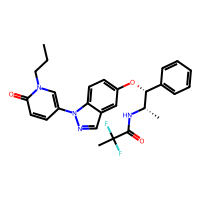
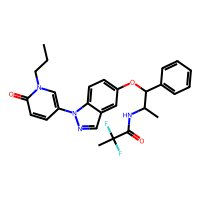
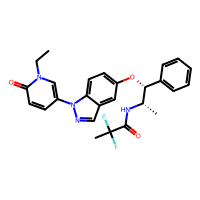
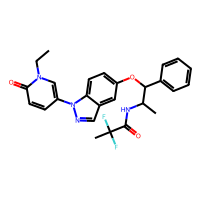
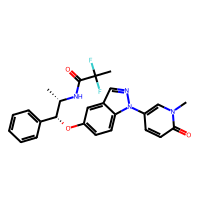
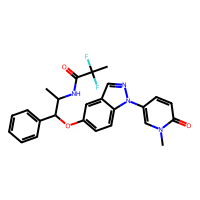
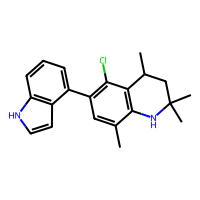
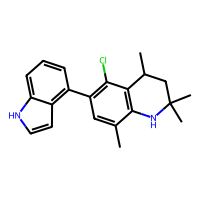
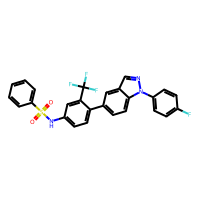
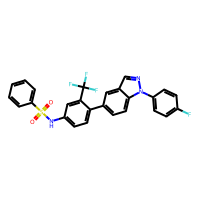
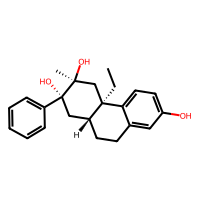
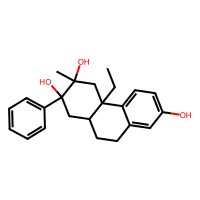
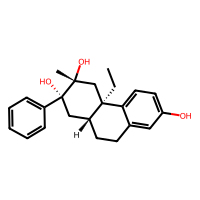
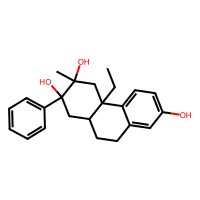
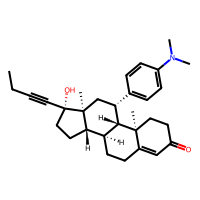
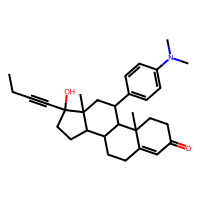
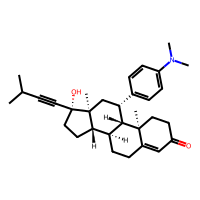
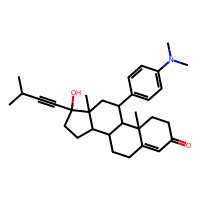
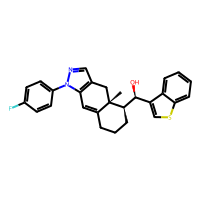
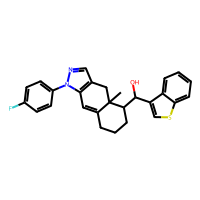
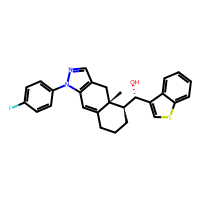
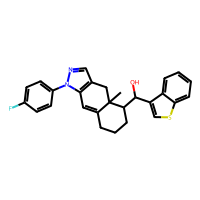
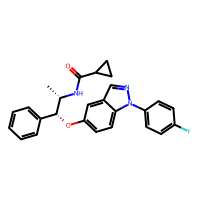
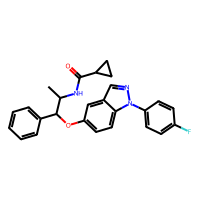
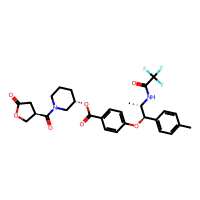
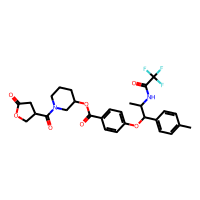
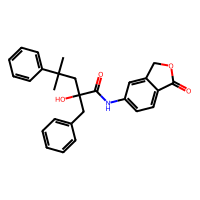
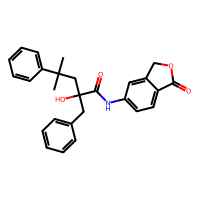
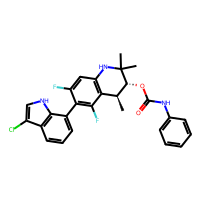
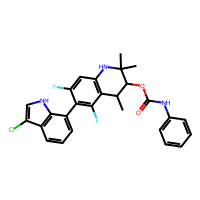
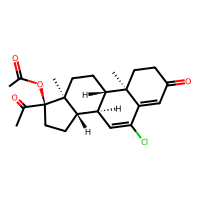
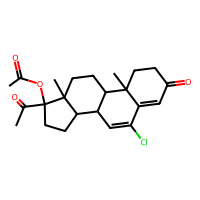
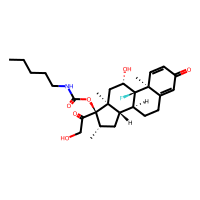
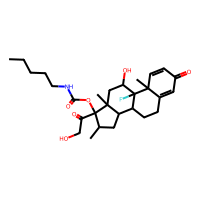

How much TC = 1:  43


----------------------------------------------------------------------------------------------------------------


DrugEx sim 0


[14:44:44] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:44:48] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:46:18] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


Delka recall setu:  616
X:  0
X:  1
X:  2
X:  3
X:  4
X:  5
X:  6
X:  7
X:  8
X:  9
X:  10
X:  11
X:  12
X:  13
X:  14
X:  15
X:  16
X:  17
X:  18
X:  19
X:  20
X:  21
X:  22
X:  23
X:  24
X:  25
X:  26
X:  27
X:  28
X:  29
X:  30
X:  31
X:  32
X:  33
X:  34
X:  35
X:  36
X:  37
X:  38
X:  39
X:  40
X:  41
X:  42
X:  43
X:  44
X:  45
X:  46
X:  47
X:  48
X:  49
X:  50
X:  51
X:  52
X:  53
X:  54
X:  55
X:  56
X:  57
X:  58
X:  59
X:  60
X:  61
X:  62
X:  63
X:  64
X:  65
X:  66
X:  67
X:  68
X:  69
X:  70
X:  71
X:  72
X:  73
X:  74
X:  75
X:  76
X:  77
X:  78
X:  79
X:  80
X:  81
X:  82
X:  83
X:  84
X:  85
X:  86
X:  87
X:  88
X:  89
X:  90
X:  91
X:  92
X:  93
X:  94
X:  95
X:  96
X:  97
X:  98
X:  99
X:  100
X:  101
X:  102
X:  103
X:  104
X:  105
X:  106
X:  107
X:  108
X:  109
X:  110
X:  111
X:  112
X:  113
X:  114
X:  115
X:  116
X:  117
X:  118
X:  119
X:  120
X:  121
X:  122
X:  123
X:  124
X:  125
X:  126
X:  127
X:  128
X:  129
X:  130
X:  131
X:  132
X:  133
X:  134
X:  13

recall_id                                 output_id   tc  \
0      [578]   [77929, 235244, 482851, 699221, 840692]  1.0   
1      [572]          [102237, 517309, 737738, 962695]  1.0   
2      [567]                                   [67513]  1.0   
3      [563]   [25548, 393657, 442285, 638499, 824836]  1.0   
4      [557]                  [361673, 468329, 751348]  1.0   
5      [556]                  [102318, 644836, 952148]  1.0   
6      [555]   [32099, 215012, 409141, 613529, 850123]  1.0   
7      [554]                          [132828, 273049]  1.0   
8      [552]   [14253, 223983, 403659, 601852, 850625]  1.0   
9      [550]                                  [957798]  1.0   
10     [549]   [77929, 235244, 482851, 699221, 840692]  1.0   
11     [548]   [10470, 206665, 404999, 620259, 827686]  1.0   
12     [543]   [10470, 206665, 404999, 620259, 827686]  1.0   
13     [542]   [46098, 221937, 404140, 612101, 849404]  1.0   
14     [538]    [1597, 211671, 432336, 601945, 814881]  1.0   
15     [537]   [77929, 235244, 482851, 699221, 840692]  1.0   
16     [535]                                  [413924]  1.0   
17     [527]                                  [224378]  1.0   
18     [520]  [191690, 273469, 418040, 738294, 813132]  1.0   
19     [515]  [191690, 273469, 418040, 738294, 813132]  1.0   
20     [460]                                  [269215]  1.0   
21     [348]   [18885, 229319, 446312, 616632, 877828]  1.0   
22     [347]                                  [540795]  1.0   
23     [277]                                  [427216]  1.0   
24     [251]                                   [56506]  1.0   
25     [242]                   [52101, 572266, 979875]  1.0   
26     [240]   [71631, 223829, 415011, 638567, 806887]  1.0   
27     [239]                                  [984721]  1.0   
28     [232]                                  [192981]  1.0   
29     [229]                                   [18111]  1.0   
30     [223]                          [153650, 648106]  1.0   
31     [222]                          [431365, 701186]  1.0   
32     [221]                                  [114684]  1.0   
33     [220]                                  [759992]  1.0   
34     [218]                          [175245, 446329]  1.0   
35     [217]     [638, 231073, 401270, 601875, 806976]  1.0   
36     [210]                          [202339, 630025]  1.0   
37     [205]          [214534, 436539, 717911, 909607]  1.0   
38     [201]                                  [314012]  1.0   
39     [199]    [9248, 203231, 402799, 610401, 800717]  1.0   
40     [198]    [7508, 221643, 406853, 691500, 802627]  1.0   
41     [196]                  [306007, 418042, 907194]  1.0   
42     [195]                          [590809, 684349]  1.0   
43     [193]                                   [37149]  1.0   
44      [55]   [67460, 216614, 503328, 606659, 814129]  1.0   
45      [39]   [73269, 222913, 497259, 623215, 806372]  1.0   
46      [38]   [73269, 222913, 497259, 623215, 806372]  1.0   
47      [34]                  [376810, 683836, 839275]  1.0   
48      [33]                                  [716139]  1.0   
49      [30]   [14456, 212550, 471723, 690728, 804914]  1.0   
50      [28]   [51148, 213972, 519421, 677901, 829866]  1.0   
51      [26]           [21479, 203620, 639113, 877582]  1.0   
52      [13]                                  [501065]  1.0   
53       [8]                          [421767, 784470]  1.0   

                                           recall_set  \
0   COc1ccc(F)cc1C(C)(C)C[C@](O)(Cc1cc2ccccc2[nH]1...   
1   Cc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2nccnc2[nH]1)C(F...   
2    Cc1ccccc1C(C)(C)CC(O)(Cc1cc2ncncc2[nH]1)C(F)(F)F   
3   COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2ccc(F)cc2[nH]1...   
4   COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2cc(F)ccc2[nH]1...   
5   COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2ncccc2[nH]1)C(...   
6   CC(C)(CC(O)(Cc1cc2ccncc2[nH]1)C(F)(F)F)c1cccc(...   
7   COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2ccncc2o1)C(F)(F)F   
8   COc1ccc(F)cc1C(C)(C)
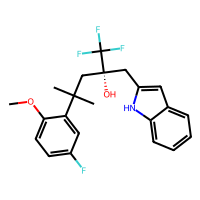
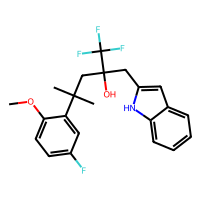
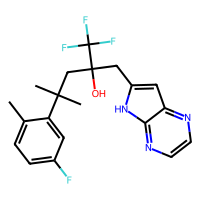
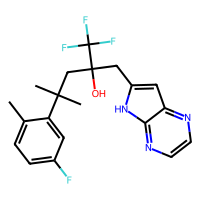
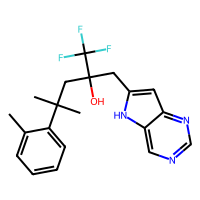
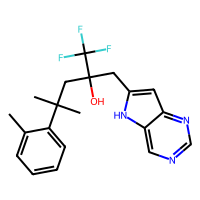
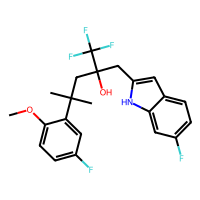
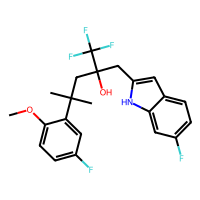
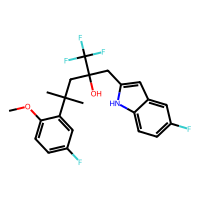
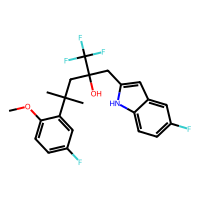
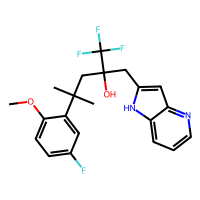
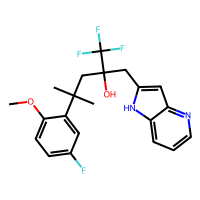
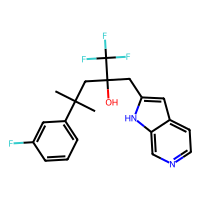
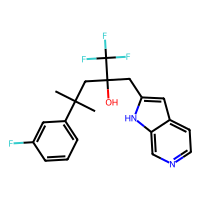
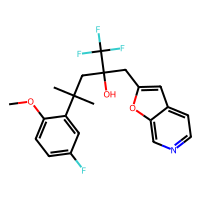
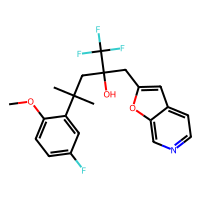
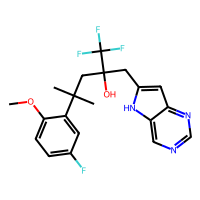
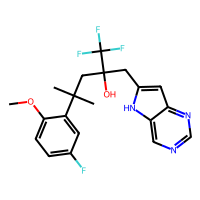
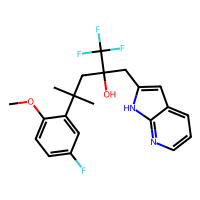
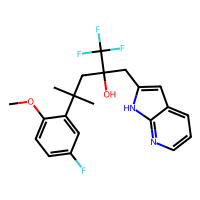
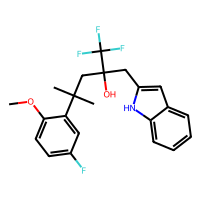
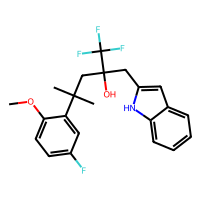
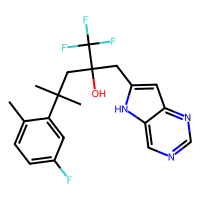
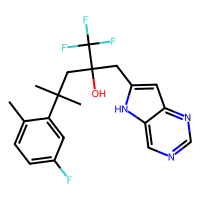
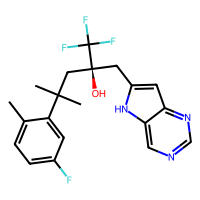
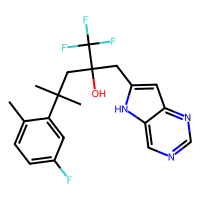
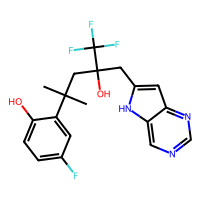
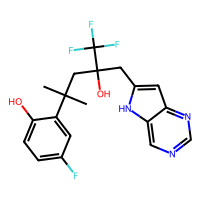
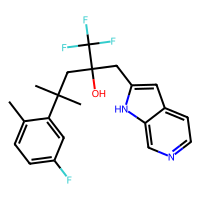
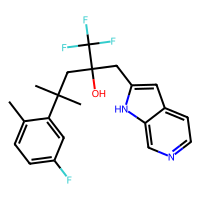
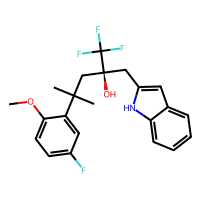
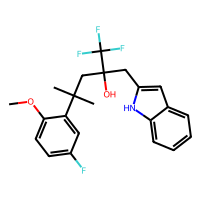
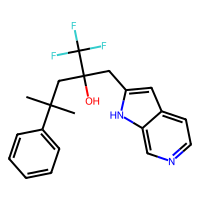
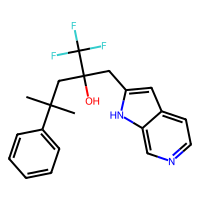
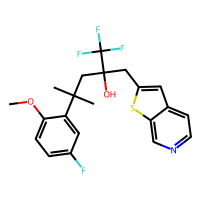
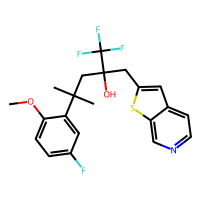
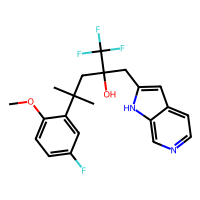
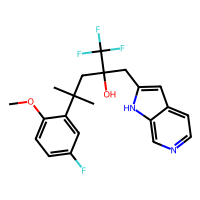
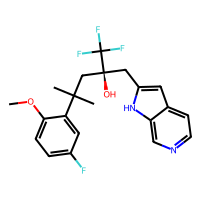
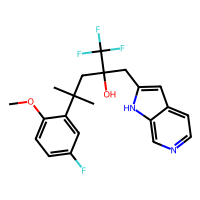
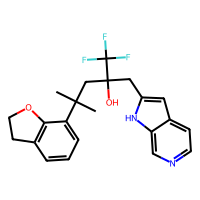
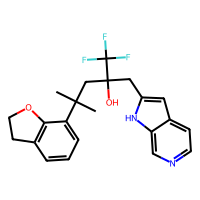
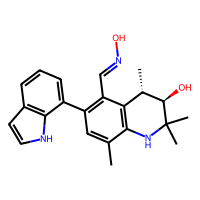
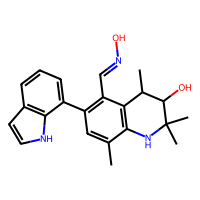
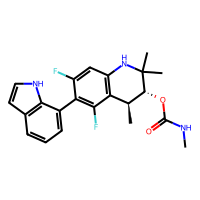
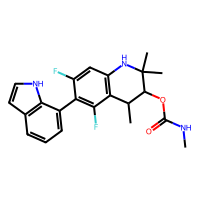
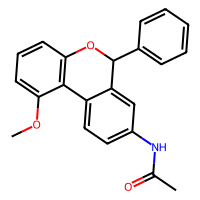
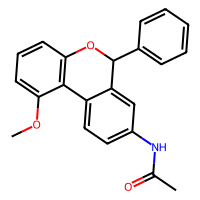
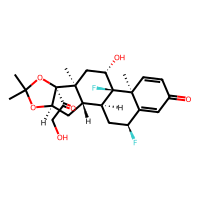
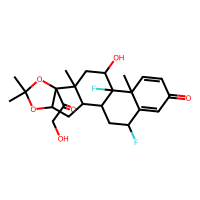
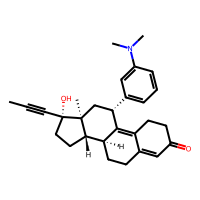
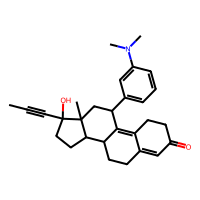
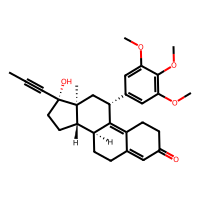
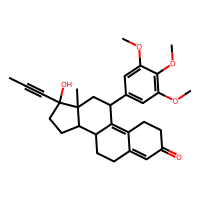
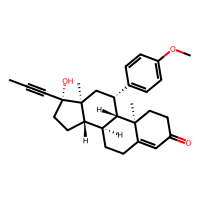
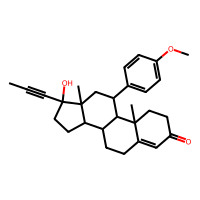
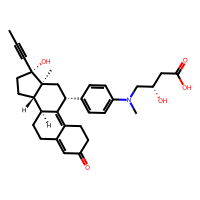
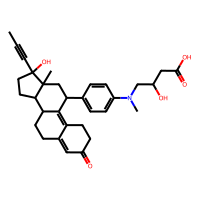
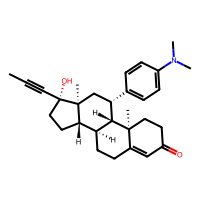
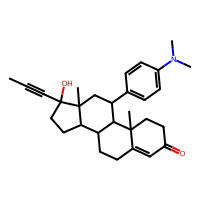
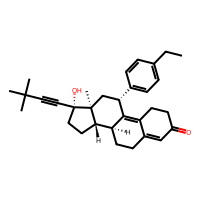
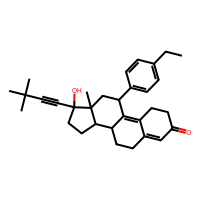
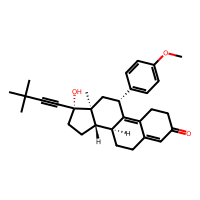
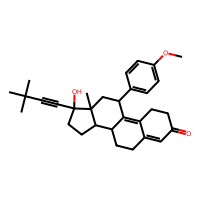
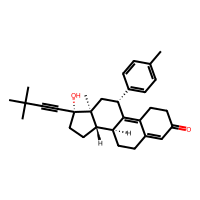
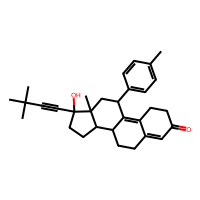
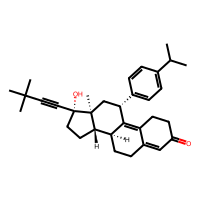
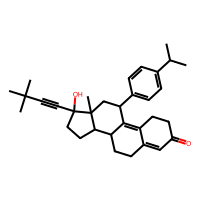
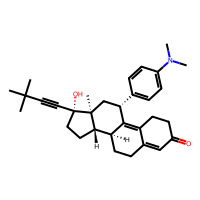
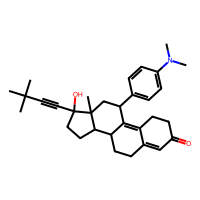
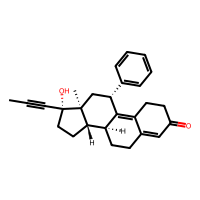
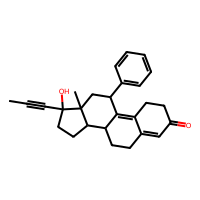
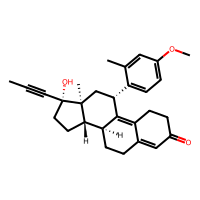
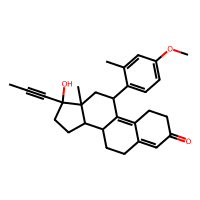
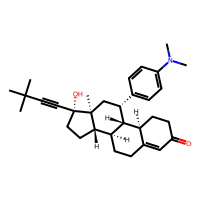
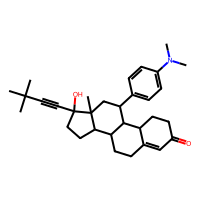
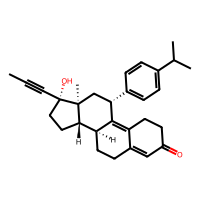
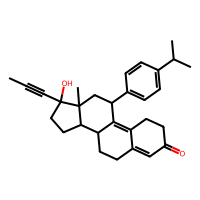
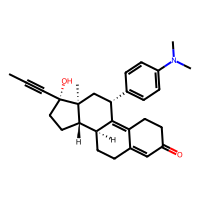
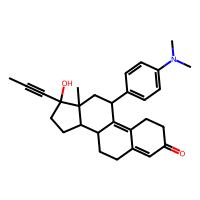
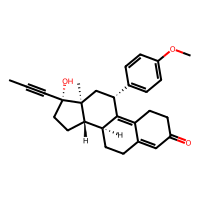
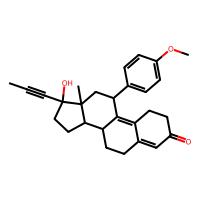
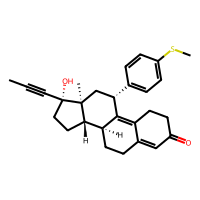
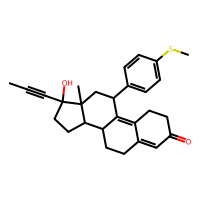
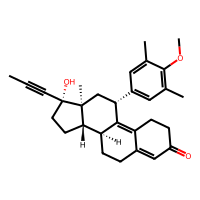
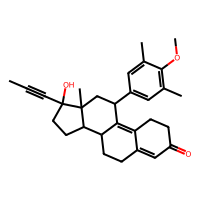
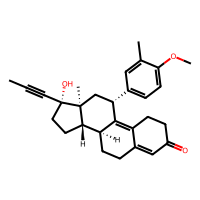
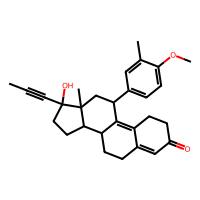
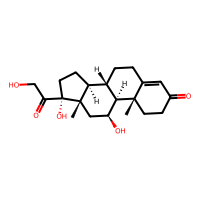
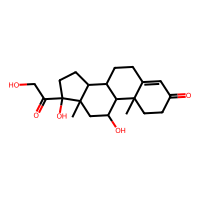
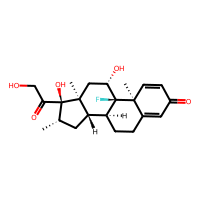
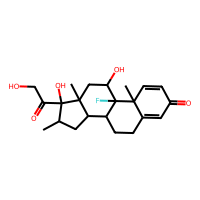
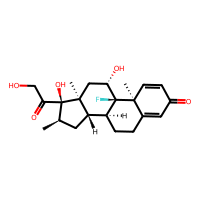
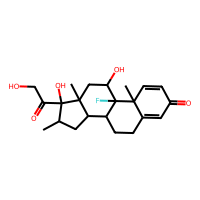
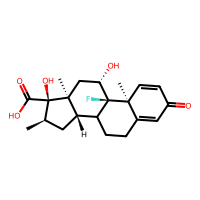
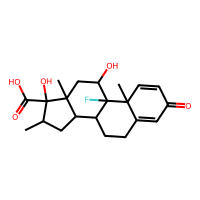
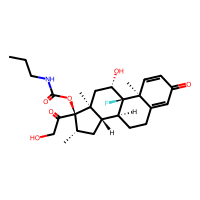
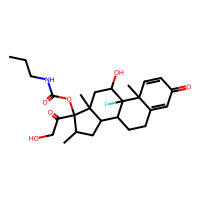
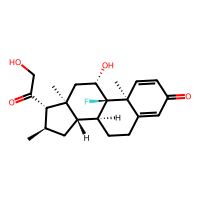
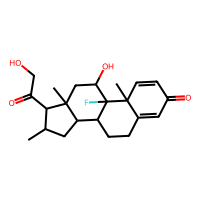
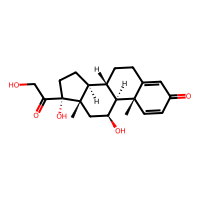
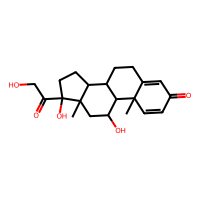
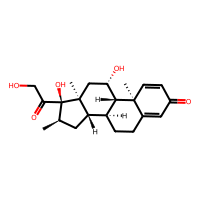
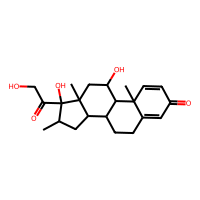
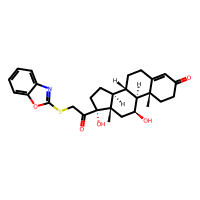
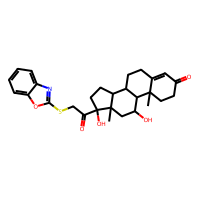
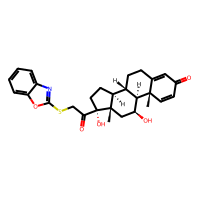
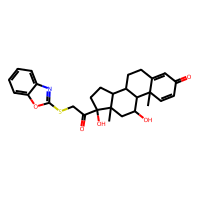

How much TC = 1:  54


----------------------------------------------------------------------------------------------------------------
Molpher sim 1
Delka recall setu:  275
X:  0
X:  1
X:  2
X:  3
X:  4
X:  5
X:  6
X:  7
X:  8
X:  9
X:  10
X:  11
X:  12
X:  13
X:  14
X:  15
X:  16
X:  17
X:  18
X:  19
X:  20
X:  21
X:  22
X:  23
X:  24
X:  25
X:  26
X:  27
X:  28
X:  29
X:  30
X:  31
X:  32
X:  33
X:  34
X:  35
X:  36
X:  37
X:  38
X:  39
X:  40
X:  41
X:  42
X:  43
X:  44
X:  45
X:  46
X:  47
X:  48
X:  49
X:  50
X:  51
X:  52
X:  53
X:  54
X:  55
X:  56
X:  57
X:  58
X:  59
X:  60
X:  61
X:  62
X:  63
X:  64
X:  65
X:  66
X:  67
X:  68
X:  69
X:  70
X:  71
X:  72
X:  73
X:  74
X:  75
X:  76
X:  77
X:  78
X:  79
X:  80
X:  81
X:  82
X:  83
X:  84
X:  85
X:  86
X:  87
X:  88
X:  89
X:  90
X:  91
X:  92
X:  93
X:  94
X:  95
X:  96
X:  97
X:  98
X:  99
X:  100
X:  101
X:  102
X:  103
X:  104
X:  105
X:  106
X:  107
X:  108
X:  109
X:  110
X:  111
X:  112
X:  113
X:  114
X:  115
X:  116


recall_id                                          output_id   tc  \
0      [269]                                           [785761]  1.0   
1      [237]                                           [939545]  1.0   
2      [235]                                           [785431]  1.0   
3      [231]                                           [953882]  1.0   
4      [203]                                   [315345, 681429]  1.0   
5      [193]                                   [652280, 734402]  1.0   
6      [155]                                             [9549]  1.0   
7      [154]                                             [9551]  1.0   
8      [126]                                   [887373, 891045]  1.0   
9      [121]                                   [751615, 887766]  1.0   
10     [119]                                           [412126]  1.0   
11     [118]                                   [157990, 259120]  1.0   
12     [117]                                   [887373, 891045]  1.0   
13     [111]                                           [143230]  1.0   
14     [108]                                           [143231]  1.0   
15      [98]                   [572525, 575657, 579211, 583854]  1.0   
16      [66]                                   [439618, 490741]  1.0   
17      [41]  [14462, 14681, 57191, 57694, 84326, 113949, 12...  1.0   

                                           recall_set  \
0   Cc1noc(=O)c2ccc(NC(=O)C(O)(CC(C)(C)c3cc(F)ccc3...   
1   CC(C)(CC(O)(Cn1ccc(=O)c2ccccc21)C(F)(F)F)c1ccccc1   
2   Cc1ccccc1C(C)(C)CC(O)(Cn1ccc(=O)c2ccccc21)C(F)...   
3       CCC(Cc1cccc2ccccc12)NS(=O)(=O)c1c(C)cc(C)cc1C   
4   COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cccc(C#N)c1)C(F)(F)F   
5   COc1ccc(F)cc1C(C)(C)CC(O)(Cc1ccc(C#N)cc1)C(F)(F)F   
6   C[C@H](NC(=O)C(C)(F)F)[C@H](Oc1ccc2c(cnn2-c2cc...   
7   C[C@H](NC(=O)C(C)(F)F)[C@H](Oc1ccc2c(cnn2-c2cc...   
8   C[C@]12Cc3cnn(-c4ccc(F)cc4)c3C=C1CCC[C@@H]2[C@...   
9   C[C@]12Cc3cnn(-c4ccc(F)cc4)c3C=C1CCC[C@@H]2[C@...   
10  C[C@]12Cc3cnn(-c4ccc(F)cc4)c3C=C1CCC[C@@H]2[C@...   
11  Cc1cc([C@H](O)[C@H]2CCCC3=Cc4c(cnn4-c4ccc(F)cc...   
12  C[C@]12Cc3cnn(-c4ccc(F)cc4)c3C=C1CCC[C@@H]2[C@...   
13  C[C@H](O)[C@H]1CCCC2=Cc3c(cnn3-c3ccc(F)cc3)C[C...   
14  CC(C)(O)[C@H]1CCCC2=Cc3c(cnn3-c3ccc(F)cc3)C[C@...   
15  COc1c(O)ccc2c1-c1ccc3c(c1/C(=C/c1cccc(-c4ccccc...   
16  COc1cccc2c1-c1ccc3c(c1C(c1ccccc1)O2)C(C)=CC(C)...   
17  Cc1noc(=O)c2ccc(NC(=O)C(O)(CC3(C4CCC4)CCCc4ccc...   

                                           output_set  \
0   CC1=NOC(=O)C2=CC=C(NC(=O)C(O)(CC(C)(C)C3=CC(F)...   
1   CC(C)(CC(O)(CN1C=CC(=O)C2=CC=CC=C21)C(F)(F)F)C...   
2   CC1=CC=CC=C1C(C)(C)CC(O)(CN1C=CC(=O)C2=CC=CC=C...   
3   CCC(CC1=C2C=CC=CC2=CC=C1)NS(=O)(=O)C1=C(C)C=C(...   
4   COC1=CC=C(F)C=C1C(C)(C)CC(O)(CC1=CC(C#N)=CC=C1...   
5   COC1=CC=C(F)C=C1C(C)(C)CC(O)(CC1=CC=C(C#N)C=C1...   
6   CC(NC(=O)C(C)(F)F)C(OC1=CC=C2C(=C1)C=NN2C1=CC=...   
7   CC(NC(=O)C(C)(F)F)C(OC1=CC=C2C(=C1)C=NN2C1=CC=...   
8   CC12CC3=C(C=C1CCCC2C(O)C1=CC=C(F)C=C1)N(C1=CC=...   
9   CC12CC3=C(C=C1CCCC2C(O)C1=CC=CC=C1)N(C1=CC=C(F...   
10  CC12CC3=C(C=C1CCCC2C(O)C1=C(F)C=CC=C1)N(C1=CC=...   
11  CC1=CC(C(O)C2CCCC3=CC4=C(C=NN4C4=CC=C(F)C=C4)C...   
12  CC12CC3=C(C=C1CCCC2C(O)C1=CC=C(F)C=C1)N(C1=CC=...   
13       CC(O)C1CCCC2=CC3=C(C=NN3C3=CC=C(F)C=C3)CC21C   
14    CC(C)(O)C1CCCC2=CC3=C(C=NN3C3=CC=C(F)C=C3)CC21C   
15  COC1=C(O)C=CC2=C1C1=CC=C3NC(C)(C)C=C(C)C3=C1C(...   
16  COC1=C2C(=CC=C1)OC(C1=CC=CC=C1)C1=C3C(C)=CC(C)...   
17  CC1=NOC(=O)C2=CC=C(NC(=O)C(O)(CC3(C4CCC4)CCCC4...   

                                     recall_compound  \
0   <rdkit.Chem.rdchem.Mol object at 0x753973df03c0>   
1   <rdkit.Chem.rdchem.Mol object at 0x753973df05f0>   
2   <rdkit.Chem.rdchem.Mol object at 0x753973df0740>   
3   <rdkit.Chem.rdchem.Mol object at 0x753973df06d0>   
4   <rdkit.Chem.rdchem.Mol object at 0x753973df07b0>   
5   <rdkit.Chem.rdchem.Mol object at 0x753973df0820>   
6   <rdkit.Chem.rdchem.Mol object at 0x753973df0890>   
7   <rdkit.Chem.rd
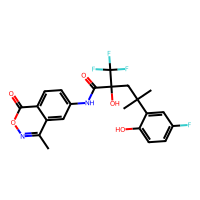
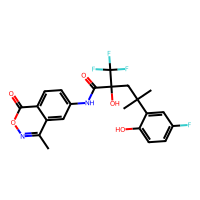
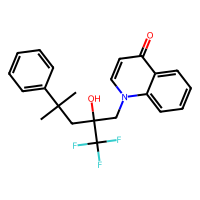
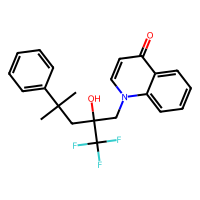
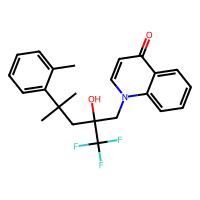
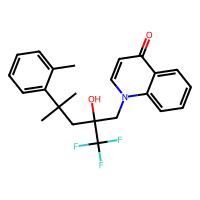
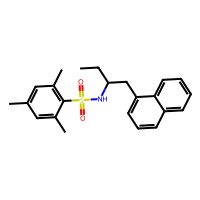
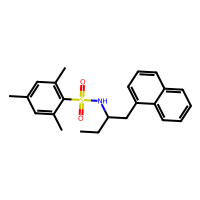
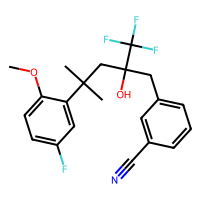
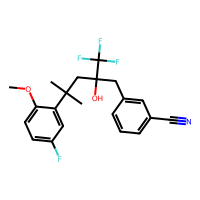
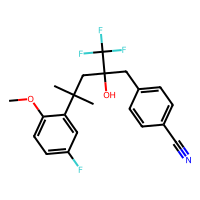
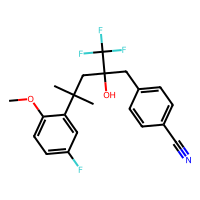
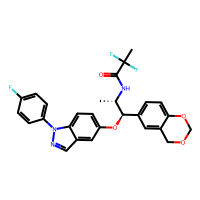
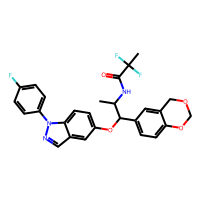
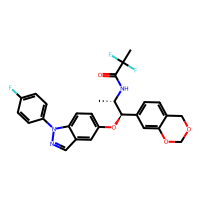
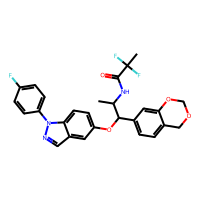
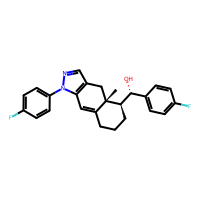
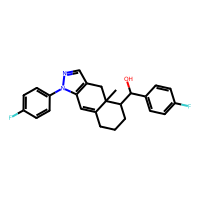
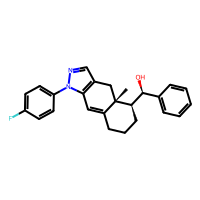
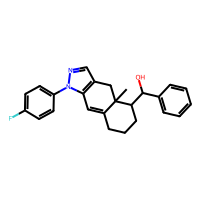
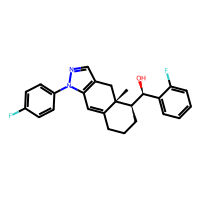
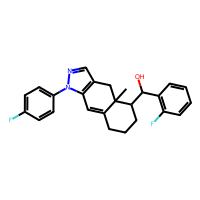
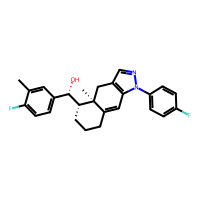
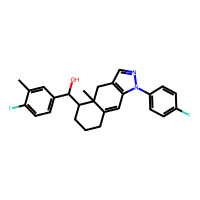
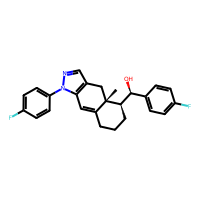
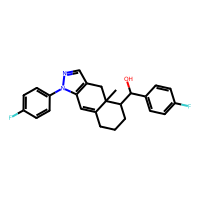
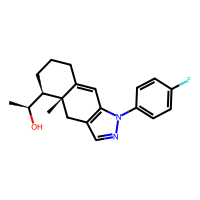
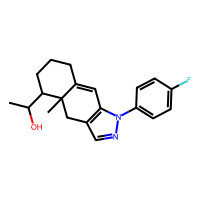
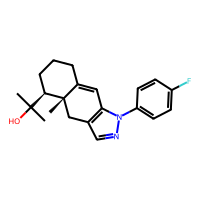
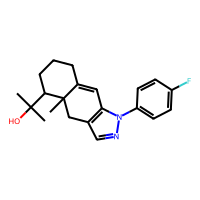
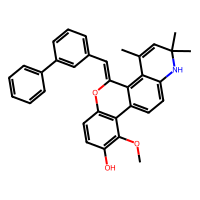
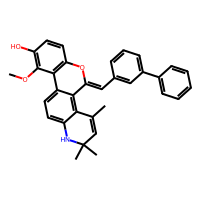
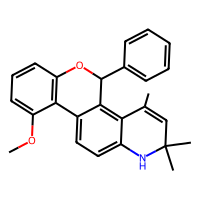
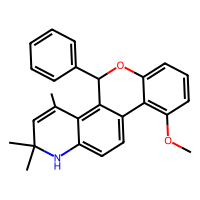
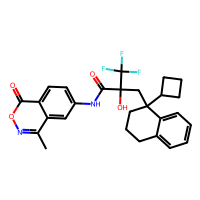
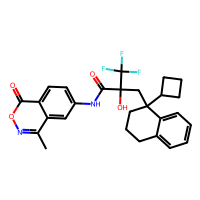

How much TC = 1:  18


----------------------------------------------------------------------------------------------------------------


DrugEx sim 1


[19:39:18] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[19:39:50] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[19:40:11] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[19:40:51] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


Delka recall setu:  275
X:  0
X:  1
X:  2
X:  3
X:  4
X:  5
X:  6
X:  7
X:  8
X:  9
X:  10
X:  11
X:  12
X:  13
X:  14
X:  15
X:  16
X:  17
X:  18
X:  19
X:  20
X:  21
X:  22
X:  23
X:  24
X:  25
X:  26
X:  27
X:  28
X:  29
X:  30
X:  31
X:  32
X:  33
X:  34
X:  35
X:  36
X:  37
X:  38
X:  39
X:  40
X:  41
X:  42
X:  43
X:  44
X:  45
X:  46
X:  47
X:  48
X:  49
X:  50
X:  51
X:  52
X:  53
X:  54
X:  55
X:  56
X:  57
X:  58
X:  59
X:  60
X:  61
X:  62
X:  63
X:  64
X:  65
X:  66
X:  67
X:  68
X:  69
X:  70
X:  71
X:  72
X:  73
X:  74
X:  75
X:  76
X:  77
X:  78
X:  79
X:  80
X:  81
X:  82
X:  83
X:  84
X:  85
X:  86
X:  87
X:  88
X:  89
X:  90
X:  91
X:  92
X:  93
X:  94
X:  95
X:  96
X:  97
X:  98
X:  99
X:  100
X:  101
X:  102
X:  103
X:  104
X:  105
X:  106
X:  107
X:  108
X:  109
X:  110
X:  111
X:  112
X:  113
X:  114
X:  115
X:  116
X:  117
X:  118
X:  119
X:  120
X:  121
X:  122
X:  123
X:  124
X:  125
X:  126
X:  127
X:  128
X:  129
X:  130
X:  131
X:  132
X:  133
X:  134
X:  13

recall_id                 output_id   tc  \
0     [206]                  [672873]  1.0   
1     [203]                  [127802]  1.0   
2     [193]                  [392490]  1.0   
3      [18]                   [89437]  1.0   
4      [16]  [128205, 250204, 656731]  1.0   

                                          recall_set  \
0  COc1ccc(F)cc1C(C)(C)C[C@@](O)(Cc1ccc(Cl)cc1)C(...   
1  COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cccc(C#N)c1)C(F)(F)F   
2  COc1ccc(F)cc1C(C)(C)CC(O)(Cc1ccc(C#N)cc1)C(F)(F)F   
3  C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...   
4  C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[C...   

                                          output_set  \
0   COc1ccc(F)cc1C(C)(C)CC(O)(Cc1ccc(Cl)cc1)C(F)(F)F   
1  COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cccc(C#N)c1)C(F)(F)F   
2  COc1ccc(F)cc1C(C)(C)CC(O)(Cc1ccc(C#N)cc1)C(F)(F)F   
3  CC12C=CC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)...   
4  CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)C...   

                                    recall_compound  \
0  <rdkit.Chem.rdchem.Mol object at 0x753978d79c80>   
1  <rdkit.Chem.rdchem.Mol object at 0x753978d79cf0>   
2  <rdkit.Chem.rdchem.Mol object at 0x753978d79c10>   
3  <rdkit.Chem.rdchem.Mol object at 0x753978d79b30>   
4  <rdkit.Chem.rdchem.Mol object at 0x753978d79d60>   

                                    output_compound  
0  <rdkit.Chem.rdchem.Mol object at 0x753978d79dd0>  
1  <rdkit.Chem.rdchem.Mol object at 0x753978d79e40>  
2  <rdkit.Chem.rdchem.Mol object at 0x753978d79eb0>  
3  <rdkit.Chem.rdchem.Mol object at 0x753978d79f20>  
4  <rdkit.Chem.rdchem.Mol object at 0x753978d79f90>
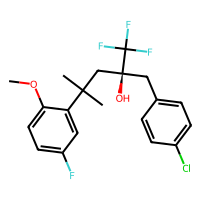
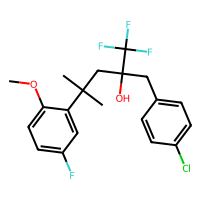
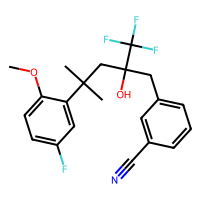
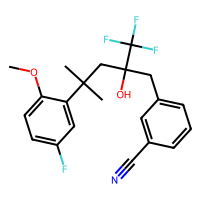
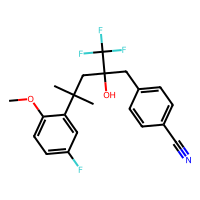
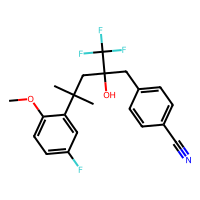
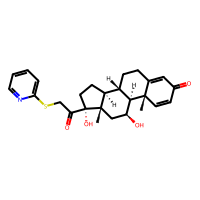
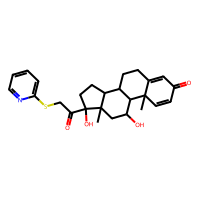
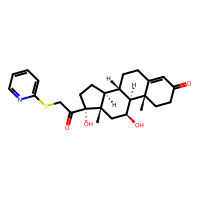
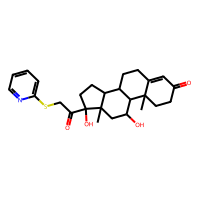

How much TC = 1:  5


----------------------------------------------------------------------------------------------------------------
Molpher sim 2
Delka recall setu:  136
X:  0
X:  1
X:  2
X:  3
X:  4
X:  5
X:  6
X:  7
X:  8
X:  9
X:  10
X:  11
X:  12
X:  13
X:  14
X:  15
X:  16
X:  17
X:  18
X:  19
X:  20
X:  21
X:  22
X:  23
X:  24
X:  25
X:  26
X:  27
X:  28
X:  29
X:  30
X:  31
X:  32
X:  33
X:  34
X:  35
X:  36
X:  37
X:  38
X:  39
X:  40
X:  41
X:  42
X:  43
X:  44
X:  45
X:  46
X:  47
X:  48
X:  49
X:  50
X:  51
X:  52
X:  53
X:  54
X:  55
X:  56
X:  57
X:  58
X:  59
X:  60
X:  61
X:  62
X:  63
X:  64
X:  65
X:  66
X:  67
X:  68
X:  69
X:  70
X:  71
X:  72
X:  73
X:  74
X:  75
X:  76
X:  77
X:  78
X:  79
X:  80
X:  81
X:  82
X:  83
X:  84
X:  85
X:  86
X:  87
X:  88
X:  89
X:  90
X:  91
X:  92
X:  93
X:  94
X:  95
X:  96
X:  97
X:  98
X:  99
X:  100
X:  101
X:  102
X:  103
X:  104
X:  105
X:  106
X:  107
X:  108
X:  109
X:  110
X:  111
X:  112
X:  113
X:  114
X:  115
X:  116
X

recall_id                                          output_id   tc  \
0     [121]                                           [988669]  1.0   
1     [119]                                   [350210, 786095]  1.0   
2     [115]  [348627, 372492, 373449, 375003, 639756, 71027...  1.0   
3     [114]                                           [437025]  1.0   
4     [113]                                           [639755]  1.0   
5     [112]                                           [834882]  1.0   
6      [79]                           [448139, 605088, 908023]  1.0   
7      [33]  [22826, 39570, 87038, 130932, 139786, 140527, ...  1.0   
8      [32]  [47398, 61789, 87762, 104139, 131864, 165934, ...  1.0   

                                          recall_set  \
0  CCC1(CC(O)(CNC(=O)c2cnn(-c3ccccc3)c2N)C(F)(F)F...   
1  CCC1(CC(O)(CNC(=O)c2cnn(-c3ccc(F)cc3F)c2N)C(F)...   
2  C[C@]12Cc3cnn(-c4ccc(F)cc4)c3C=C1CCC[C@@H]2[C@...   
3  Cc1ccc(C[C@H](O)[C@H]2CCCC3=Cc4c(cnn4-c4ccc(F)...   
4  C[C@]12Cc3cnn(-c4ccc(F)cc4)c3C=C1CCC[C@@H]2[C@...   
5  CC(C)(CC(O)(Cn1ccc(=O)c2ccccc21)C(F)(F)F)c1ccc...   
6  C[C@H](NC(=O)C(C)(F)F)[C@H](Oc1ccc2c(cnn2-c2cc...   
7  Cc1noc(=O)c2ccc(NC(=O)C(O)(CC3(C4CCCCC4)CCCc4c...   
8  COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2ccncc2[nH]1)C1...   

                                          output_set  \
0  CCC1(CC(O)(CNC(=O)C2=C(N)N(C3=CC=CC=C3)N=C2)C(...   
1  CCC1(CC(O)(CNC(=O)C2=C(N)N(C3=CC=C(F)C=C3F)N=C...   
2  CC12CC3=C(C=C1CCCC2C(O)CC1=CC=CC=C1)N(C1=CC=C(...   
3  CC1=CC=C(CC(O)C2CCCC3=CC4=C(C=NN4C4=CC=C(F)C=C...   
4  CC12CC3=C(C=C1CCCC2C(O)CC1=CC=C(F)C=C1)N(C1=CC...   
5  CC(C)(CC(O)(CN1C=CC(=O)C2=CC=CC=C21)C(F)(F)F)C...   
6  CC(NC(=O)C(C)(F)F)C(OC1=CC=C2C(=C1)C=NN2C1=CC=...   
7  CC1=NOC(=O)C2=CC=C(NC(=O)C(O)(CC3(C4CCCCC4)CCC...   
8  COC1=CC=C(F)C=C1C(C)(C)CC(O)(CC1=CC2=CC=NC=C2N...   

                                    recall_compound  \
0  <rdkit.Chem.rdchem.Mol object at 0x753961b4e430>   
1  <rdkit.Chem.rdchem.Mol object at 0x753974d27660>   
2  <rdkit.Chem.rdchem.Mol object at 0x753974d275f0>   
3  <rdkit.Chem.rdchem.Mol object at 0x753974d276d0>   
4  <rdkit.Chem.rdchem.Mol object at 0x753974d27740>   
5  <rdkit.Chem.rdchem.Mol object at 0x753974d277b0>   
6  <rdkit.Chem.rdchem.Mol object at 0x753974d27820>   
7  <rdkit.Chem.rdchem.Mol object at 0x753974d27890>   
8  <rdkit.Chem.rdchem.Mol object at 0x753974d27900>   

                                    output_compound  
0  <rdkit.Chem.rdchem.Mol object at 0x753974d27970>  
1  <rdkit.Chem.rdchem.Mol object at 0x753974d279e0>  
2  <rdkit.Chem.rdchem.Mol object at 0x753974d27a50>  
3  <rdkit.Chem.rdchem.Mol object at 0x753974d27ac0>  
4  <rdkit.Chem.rdchem.Mol object at 0x753974d27b30>  
5  <rdkit.Chem.rdchem.Mol object at 0x753974d27ba0>  
6  <rdkit.Chem.rdchem.Mol object at 0x753974d27c10>  
7  <rdkit.Chem.rdchem.Mol object at 0x753974d27c80>  
8  <rdkit.Chem.rdchem.Mol object at 0x753974d27cf0>
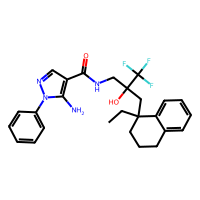
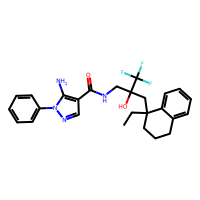
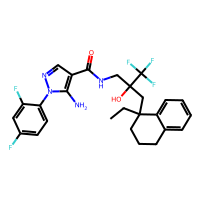
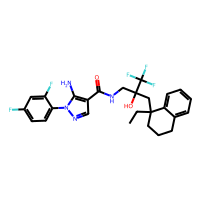
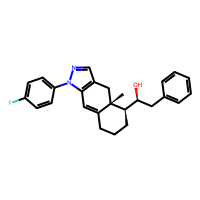
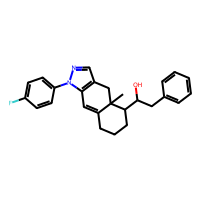
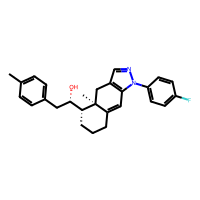
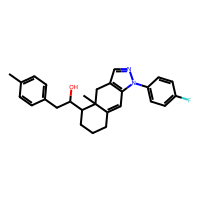
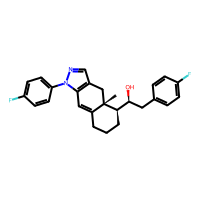
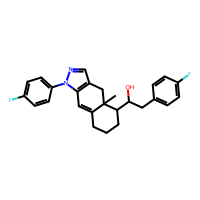
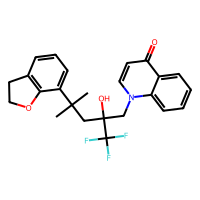
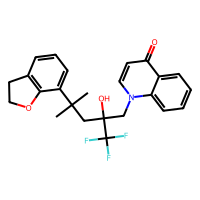
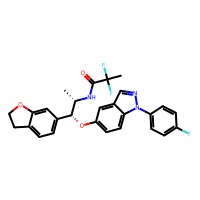
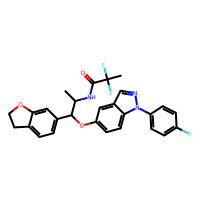
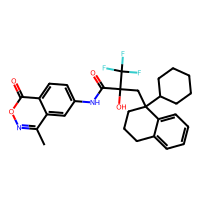
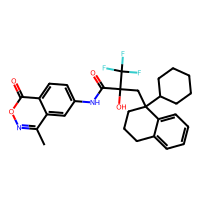
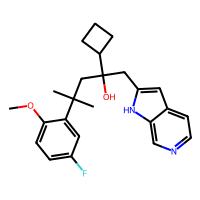
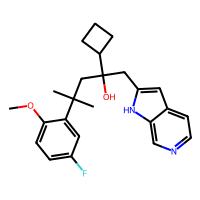

How much TC = 1:  9


----------------------------------------------------------------------------------------------------------------


DrugEx sim 2
Delka recall setu:  136
X:  0
X:  1
X:  2
X:  3
X:  4
X:  5
X:  6
X:  7
X:  8
X:  9
X:  10
X:  11
X:  12
X:  13
X:  14
X:  15
X:  16
X:  17
X:  18
X:  19
X:  20
X:  21
X:  22
X:  23
X:  24
X:  25
X:  26
X:  27
X:  28
X:  29
X:  30
X:  31
X:  32
X:  33
X:  34
X:  35
X:  36
X:  37
X:  38
X:  39
X:  40
X:  41
X:  42
X:  43
X:  44
X:  45
X:  46
X:  47
X:  48
X:  49
X:  50
X:  51
X:  52
X:  53
X:  54
X:  55
X:  56
X:  57
X:  58
X:  59
X:  60
X:  61
X:  62
X:  63
X:  64
X:  65
X:  66
X:  67
X:  68
X:  69
X:  70
X:  71
X:  72
X:  73
X:  74
X:  75
X:  76
X:  77
X:  78
X:  79
X:  80
X:  81
X:  82
X:  83
X:  84
X:  85
X:  86
X:  87
X:  88
X:  89
X:  90
X:  91
X:  92
X:  93
X:  94
X:  95
X:  96
X:  97
X:  98
X:  99
X:  100
X:  101
X:  102
X:  103
X:  104
X:  105
X:  106
X:  107
X:  108
X:  109
X:  110
X:  111
X:  112
X:  113
X:  114
X:  115
X:  116


recall_id         output_id   tc  \
0      [59]          [504931]  1.0   
1      [53]           [68473]  1.0   
2      [39]  [151012, 721819]  1.0   

                                          recall_set  \
0  CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...   
1  COc1c(O)ccc2c1-c1ccc3c(c1/C(=C/c1ccccc1Cl)O2)C...   
2  COc1c(O)ccc2c1-c1ccc3c(c1/C(=C/c1ccc(O)cc1)O2)...   

                                          output_set  \
0  CC#CC1(O)CCC2C3CCC4=CC(=O)CCC4=C3C(c3ccc(Oc4cc...   
1  COc1c(O)ccc2c1-c1ccc3c(c1C(=Cc1ccccc1Cl)O2)C(C...   
2  COc1c(O)ccc2c1-c1ccc3c(c1C(=Cc1ccc(O)cc1)O2)C(...   

                                    recall_compound  \
0  <rdkit.Chem.rdchem.Mol object at 0x753967010970>   
1  <rdkit.Chem.rdchem.Mol object at 0x753967010900>   
2  <rdkit.Chem.rdchem.Mol object at 0x753967010ac0>   

                                    output_compound  
0  <rdkit.Chem.rdchem.Mol object at 0x753967010890>  
1  <rdkit.Chem.rdchem.Mol object at 0x753967010820>  
2  <rdkit.Chem.rdchem.Mol object at 0x7539670107b0>
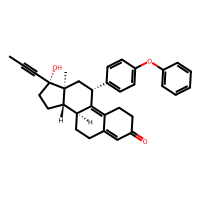
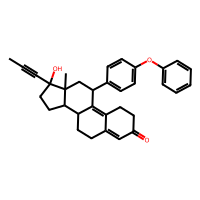
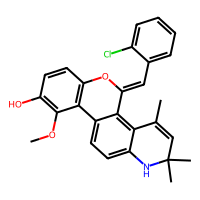
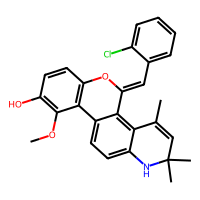
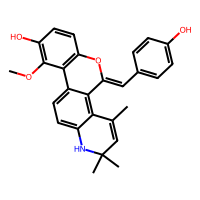
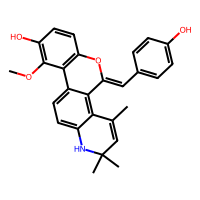

How much TC = 1:  3


----------------------------------------------------------------------------------------------------------------
Molpher sim 3
Delka recall setu:  80
X:  0
X:  1
X:  2
X:  3
X:  4
X:  5
X:  6
X:  7
X:  8
X:  9
X:  10
X:  11
X:  12
X:  13
X:  14
X:  15
X:  16
X:  17
X:  18
X:  19
X:  20
X:  21
X:  22
X:  23
X:  24
X:  25
X:  26
X:  27
X:  28
X:  29
X:  30
X:  31
X:  32
X:  33
X:  34
X:  35
X:  36
X:  37
X:  38
X:  39
X:  40
X:  41
X:  42
X:  43
X:  44
X:  45
X:  46
X:  47
X:  48
X:  49
X:  50
X:  51
X:  52
X:  53
X:  54
X:  55
X:  56
X:  57
X:  58
X:  59
X:  60
X:  61
X:  62
X:  63
X:  64
X:  65
X:  66
X:  67
X:  68
X:  69
X:  70
X:  71
X:  72
X:  73
X:  74
X:  75
X:  76
X:  77
X:  78
X:  79


recall_id                                          output_id   tc  \
0       [76]  [140961, 153813, 176175, 219405, 244863, 27669...  1.0   
1       [74]                                           [200410]  1.0   
2       [62]                                           [831883]  1.0   
3       [60]                                    [81118, 960845]  1.0   
4       [39]                           [269012, 269888, 273908]  1.0   
5       [29]  [111299, 153653, 760108, 787843, 799613, 81836...  1.0   
6       [28]  [111299, 153653, 760108, 787843, 799613, 81836...  1.0   
7       [25]  [14468, 33555, 146465, 221997, 222073, 222151,...  1.0   
8       [23]  [15515, 22424, 66300, 83876, 84954, 104409, 11...  1.0   
9       [22]  [15515, 22424, 66300, 83876, 84954, 104409, 11...  1.0   
10       [8]                                   [393881, 707408]  1.0   

                                           recall_set  \
0   COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2ccncc2[nH]1)C1CC1   
1   COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2cnccc2[nH]1)C1CC1   
2   CCC1(CC(O)(Cn2ccc(=O)c3ccccc32)C(F)(F)F)CCCc2c...   
3   CC(C)(CC(O)(C(=O)Nc1ccc2c(c1)COC2=O)C(F)(F)F)c...   
4   C[C@H](NC(=O)C(C)(F)F)[C@H](Oc1ccc2c(cnn2-c2cc...   
5   C[C@H](NC(=O)C(C)(F)F)[C@H](Oc1ccc2c(cnn2-c2cc...   
6   C[C@H](NC(=O)C(C)(F)F)[C@H](Oc1ccc2c(cnn2-c2cc...   
7   Cc1noc(=O)c2ccc(NC(=O)C(O)(CC3(C4CC4)CCCc4cccc...   
8   Cc1noc(=O)c2ccc(NC(=O)C(O)(CC3(C4CCCC4)CCCc4cc...   
9   Cc1noc(=O)c2ccc(NC(=O)[C@](O)(C[C@@]3(C4CCCC4)...   
10  CC/C=C\CC1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)...   

                                           output_set  \
0   COC1=CC=C(F)C=C1C(C)(C)CC(O)(CC1=CC2=CC=NC=C2N...   
1   COC1=CC=C(F)C=C1C(C)(C)CC(O)(CC1=CC2=CN=CC=C2N...   
2   CCC1(CC(O)(CN2C=CC(=O)C3=CC=CC=C32)C(F)(F)F)CC...   
3   CC(C)(CC(O)(C(=O)NC1=CC=C2C(=O)OCC2=C1)C(F)(F)...   
4   CC(NC(=O)C(C)(F)F)C(OC1=CC=C2C(=C1)C=NN2C1=CN(...   
5   CC(NC(=O)C(C)(F)F)C(OC1=CC=C2C(=C1)C=NN2C1=CC=...   
6   CC(NC(=O)C(C)(F)F)C(OC1=CC=C2C(=C1)C=NN2C1=CC=...   
7   CC1=NOC(=O)C2=CC=C(NC(=O)C(O)(CC3(C4CC4)CCCC4=...   
8   CC1=NOC(=O)C2=CC=C(NC(=O)C(O)(CC3(C4CCCC4)CCCC...   
9   CC1=NOC(=O)C2=CC=C(NC(=O)C(O)(CC3(C4CCCC4)CCCC...   
10  CCC=CCC1OC2=C(C(OC)=CC=C2)C2=CC=C3NC(C)(C)C=C(...   

                                     recall_compound  \
0   <rdkit.Chem.rdchem.Mol object at 0x7539767b2820>   
1   <rdkit.Chem.rdchem.Mol object at 0x7539767b27b0>   
2   <rdkit.Chem.rdchem.Mol object at 0x7539767b26d0>   
3   <rdkit.Chem.rdchem.Mol object at 0x7539767b2890>   
4   <rdkit.Chem.rdchem.Mol object at 0x7539767b2900>   
5   <rdkit.Chem.rdchem.Mol object at 0x7539767b2970>   
6   <rdkit.Chem.rdchem.Mol object at 0x7539767b29e0>   
7   <rdkit.Chem.rdchem.Mol object at 0x7539767b2a50>   
8   <rdkit.Chem.rdchem.Mol object at 0x7539767b2ac0>   
9   <rdkit.Chem.rdchem.Mol object at 0x7539767b2b30>   
10  <rdkit.Chem.rdchem.Mol object at 0x7539767b2ba0>   

                                     output_compound  
0   <rdkit.Chem.rdchem.Mol object at 0x7539767b2c10>  
1   <rdkit.Chem.rdchem.Mol object at 0x7539767b2c80>  
2   <rdkit.Chem.rdchem.Mol object at 0x7539767b2cf0>  
3   <rdkit.Chem.rdchem.Mol object at 0x7539767b2d60>  
4   <rdkit.Chem.rdchem.Mol object at 0x7539767b2dd0>  
5   <rdkit.Chem.rdchem.Mol object at 0x7539767b2e40>  
6   <rdkit.Chem.rdchem.Mol object at 0x7539767b2eb0>  
7   <rdkit.Chem.rdchem.Mol object at 0x7539767b2f20>  
8   <rdkit.Chem.rdchem.Mol object at 0x7539767b2f90>  
9   <rdkit.Chem.rdchem.Mol object at 0x7539767b3040>  
10  <rdkit.Chem.rdchem.Mol object at 0x7539767b30b0>
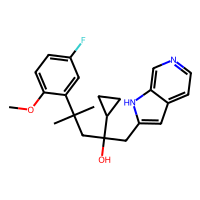
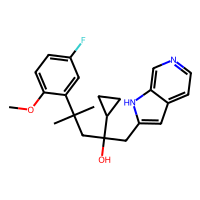
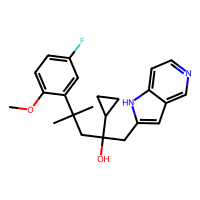
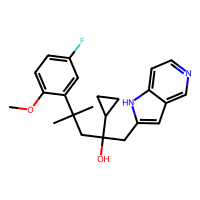
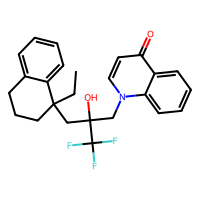
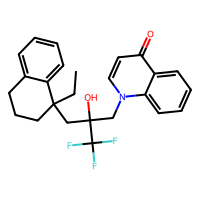
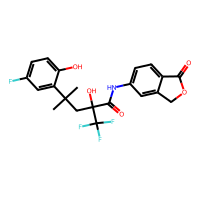
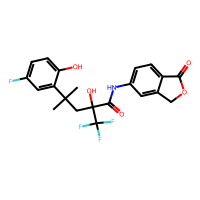
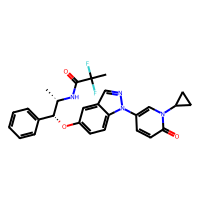
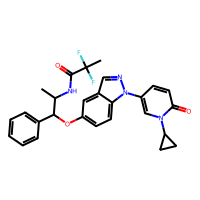
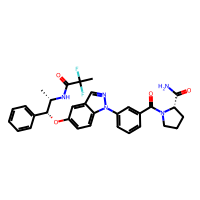
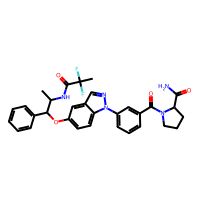
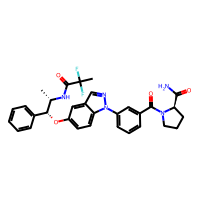
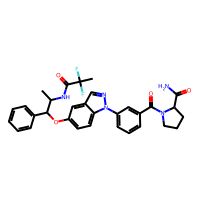
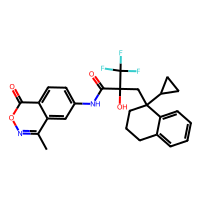
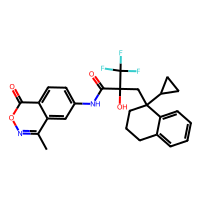
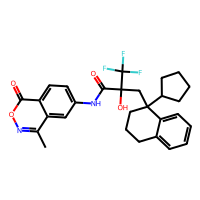
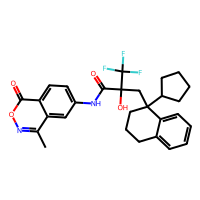
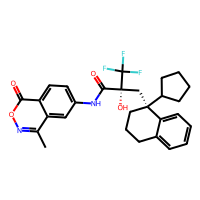
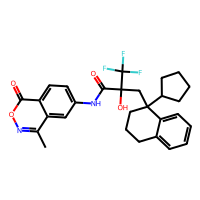
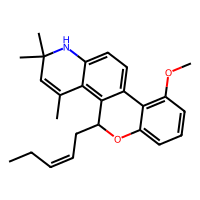
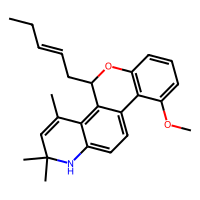

How much TC = 1:  11


----------------------------------------------------------------------------------------------------------------


DrugEx sim 3


[23:06:06] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[23:07:55] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


Delka recall setu:  80
X:  0
X:  1
X:  2
X:  3
X:  4
X:  5
X:  6
X:  7
X:  8
X:  9
X:  10
X:  11
X:  12
X:  13
X:  14
X:  15
X:  16
X:  17
X:  18
X:  19
X:  20
X:  21
X:  22
X:  23
X:  24
X:  25
X:  26
X:  27
X:  28
X:  29
X:  30
X:  31
X:  32
X:  33
X:  34
X:  35
X:  36
X:  37
X:  38
X:  39
X:  40
X:  41
X:  42
X:  43
X:  44
X:  45
X:  46
X:  47
X:  48
X:  49
X:  50
X:  51
X:  52
X:  53
X:  54
X:  55
X:  56
X:  57
X:  58
X:  59
X:  60
X:  61
X:  62
X:  63
X:  64
X:  65
X:  66
X:  67
X:  68
X:  69
X:  70
X:  71
X:  72
X:  73
X:  74
X:  75
X:  76
X:  77
X:  78
X:  79


recall_id         output_id   tc  \
0      [13]  [184758, 538336]  1.0   

                                          recall_set  \
0  C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[C...   

                                          output_set  \
0  CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)C...   

                                    recall_compound  \
0  <rdkit.Chem.rdchem.Mol object at 0x75396a45cac0>   

                                    output_compound  
0  <rdkit.Chem.rdchem.Mol object at 0x753974cc99e0>
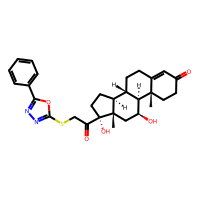
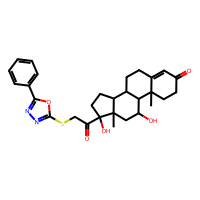

How much TC = 1:  1


----------------------------------------------------------------------------------------------------------------
Molpher sim 4
Delka recall setu:  47
X:  0
X:  1
X:  2
X:  3
X:  4
X:  5
X:  6
X:  7
X:  8
X:  9
X:  10
X:  11
X:  12
X:  13
X:  14
X:  15
X:  16
X:  17
X:  18
X:  19
X:  20
X:  21
X:  22
X:  23
X:  24
X:  25
X:  26
X:  27
X:  28
X:  29
X:  30
X:  31
X:  32
X:  33
X:  34
X:  35
X:  36
X:  37
X:  38
X:  39
X:  40
X:  41
X:  42
X:  43
X:  44
X:  45
X:  46


recall_id                                          output_id   tc  \
0      [38]                                           [982221]  1.0   
1      [25]                                           [494709]  1.0   
2      [15]  [48711, 59467, 95653, 108288, 150369, 187897, ...  1.0   
3      [13]                                           [965315]  1.0   

                                          recall_set  \
0  Cc1noc(=O)c2ccc(NC(=O)C(O)(CC(C)(C)c3cccc4c3OC...   
1  COc1c(O)ccc2c1-c1ccc3c(c1/C(=C/c1ccc(-c4ccccc4...   
2  COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2ccncc2[nH]1)C1...   
3  C[C@H](NC(=O)c1ccccc1)[C@H](Oc1ccc2c(cnn2-c2cc...   

                                          output_set  \
0  CC1=NOC(=O)C2=CC=C(NC(=O)C(O)(CC(C)(C)C3=CC=CC...   
1  COC1=C(O)C=CC2=C1C1=CC=C3NC(C)(C)C=C(C)C3=C1C(...   
2  COC1=CC=C(F)C=C1C(C)(C)CC(O)(CC1=CC2=CC=NC=C2N...   
3  CC(NC(=O)C1=CC=CC=C1)C(OC1=CC=C2C(=C1)C=NN2C1=...   

                                    recall_compound  \
0  <rdkit.Chem.rdchem.Mol object at 0x753973b59580>   
1  <rdkit.Chem.rdchem.Mol object at 0x753973b59510>   
2  <rdkit.Chem.rdchem.Mol object at 0x753973b594a0>   
3  <rdkit.Chem.rdchem.Mol object at 0x753973b593c0>   

                                    output_compound  
0  <rdkit.Chem.rdchem.Mol object at 0x753973b595f0>  
1  <rdkit.Chem.rdchem.Mol object at 0x753973b59660>  
2  <rdkit.Chem.rdchem.Mol object at 0x753973b596d0>  
3  <rdkit.Chem.rdchem.Mol object at 0x753973b59740>
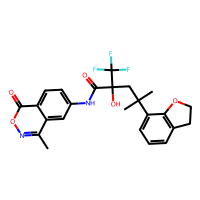
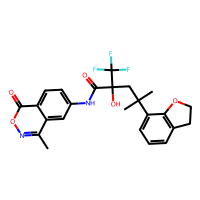
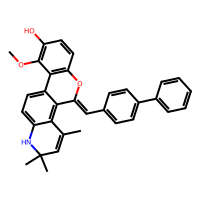
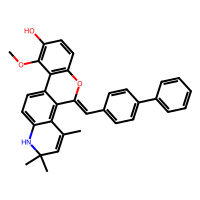
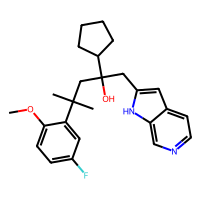
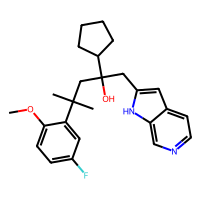
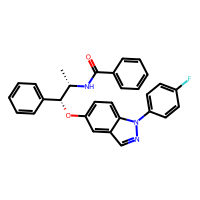
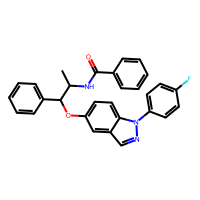

How much TC = 1:  4


----------------------------------------------------------------------------------------------------------------


DrugEx sim 4


[23:51:35] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[23:51:56] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[23:54:30] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


Delka recall setu:  47
X:  0
X:  1
X:  2
X:  3
X:  4
X:  5
X:  6
X:  7
X:  8
X:  9
X:  10
X:  11
X:  12
X:  13
X:  14
X:  15
X:  16
X:  17
X:  18
X:  19
X:  20
X:  21
X:  22
X:  23
X:  24
X:  25
X:  26
X:  27
X:  28
X:  29
X:  30
X:  31
X:  32
X:  33
X:  34
X:  35
X:  36
X:  37
X:  38
X:  39
X:  40
X:  41
X:  42
X:  43
X:  44
X:  45
X:  46


recall_id output_id   tc                                         recall_set  \
0       [3]  [925643]  1.0  C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[C...   

                                          output_set  \
0  CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(OC(=O)c1...   

                                    recall_compound  \
0  <rdkit.Chem.rdchem.Mol object at 0x75396af0a3c0>   

                                    output_compound  
0  <rdkit.Chem.rdchem.Mol object at 0x75396d6d5900>
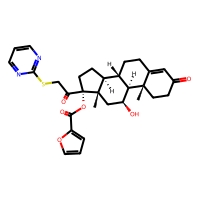
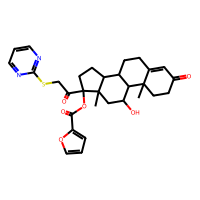

How much TC = 1:  1


In [15]:
data = {}
for type in ['sim']:
    for num in range(5):
        molpher_set = pd.read_csv(f"data/output_sets/Glucocorticoid_receptor/cOS_Molpher_{type}_{num}_one_column.csv", header=None)
        molpher_set.columns = ['virtual_compounds_smiles']
        molpher_set = molpher_set
        
        drugex_set = pd.read_csv(f"data/output_sets/Glucocorticoid_receptor/cOS_DrugEx_{type}_{num}_one_column.csv", header=None)
        drugex_set.columns = ['virtual_compounds_smiles']
        drugex_set = drugex_set

        recall_set = pd.read_csv(f"data/input_recall_sets/Glucocorticoid_receptor/RS_Glucocorticoid_receptor_{type}_{num}.csv", header=None)
        recall_set.columns = ['canonical_smiles']
        print("\n")
        print("----------------------------------------------------------------------------------------------------------------")
        print(f"Molpher {type} {num}")
        high_TC_recall_set_Molpher, array_Molpher= KL_divergence_prep_1(recall_set, molpher_set, 'canonical_smiles', 'virtual_compounds_smiles')
        dff = pd.DataFrame(data = high_TC_recall_set_Molpher)
        dff.to_csv(f"data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/analysis_compounds/high_TC_recall_Molpher_{num}",header=None, index = False)
        array_Molpher.to_csv(f"data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/analysis_compounds/array_with_tc_1_recall_Molpher_{num}",index = False)
        print("\n")
        print("----------------------------------------------------------------------------------------------------------------")
        print("\n")
        print(f"DrugEx {type} {num}")
        
        high_TC_recall_set_DrugEx, array_DrugEx = KL_divergence_prep_1(recall_set, drugex_set, 'canonical_smiles', 'virtual_compounds_smiles')
        dff_ = pd.DataFrame(data = high_TC_recall_set_DrugEx)
        dff_.to_csv(f"data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/analysis_compounds/high_TC_recall_DrugEx_{num}",header=None, index = False)
        array_DrugEx.to_csv(f"data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/analysis_compounds/array_with_tc_1_recall_DrugEx_{num}", index = False)


        data[f'generator_1_{type}_{num}'] = high_TC_recall_set_Molpher
        data[f'generator_2_{type}_{num}'] = high_TC_recall_set_DrugEx
#data 


In [45]:
data = {
    'generator_1_dis_0' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/dis/analysis_compounds/high_TC_recall_Molpher_0', header = None)).reshape(202,),
    'generator_1_dis_1' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/dis/analysis_compounds/high_TC_recall_Molpher_1', header = None)).reshape(120,),
    'generator_1_dis_2' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/dis/analysis_compounds/high_TC_recall_Molpher_2', header = None)).reshape(211,),
    'generator_1_dis_3' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/dis/analysis_compounds/high_TC_recall_Molpher_3', header = None)).reshape(266,),
    'generator_1_dis_4' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/dis/analysis_compounds/high_TC_recall_Molpher_4', header = None)).reshape(355,),
    'generator_2_dis_0' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/dis/analysis_compounds/high_TC_recall_DrugEx_0', header = None)).reshape(202,),
    'generator_2_dis_1' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/dis/analysis_compounds/high_TC_recall_DrugEx_1', header = None)).reshape(120,),
    'generator_2_dis_2' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/dis/analysis_compounds/high_TC_recall_DrugEx_2', header = None)).reshape(211,),
    'generator_2_dis_3' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/dis/analysis_compounds/high_TC_recall_DrugEx_3', header = None)).reshape(266,),
    'generator_2_dis_4' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/dis/analysis_compounds/high_TC_recall_DrugEx_4', header = None)).reshape(355,),

    'generator_1_sim_0' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/sim/analysis_compounds/high_TC_recall_Molpher_0', header = None)).reshape(616,),
    'generator_1_sim_1' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/sim/analysis_compounds/high_TC_recall_Molpher_1', header = None)).reshape(275,),
    'generator_1_sim_2' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/sim/analysis_compounds/high_TC_recall_Molpher_2', header = None)).reshape(136,),
    'generator_1_sim_3' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/sim/analysis_compounds/high_TC_recall_Molpher_3', header = None)).reshape(80,),
    'generator_1_sim_4' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/sim/analysis_compounds/high_TC_recall_Molpher_4', header = None)).reshape(47,),
    'generator_2_sim_0' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/sim/analysis_compounds/high_TC_recall_DrugEx_0', header = None)).reshape(616,),
    'generator_2_sim_1' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/sim/analysis_compounds/high_TC_recall_DrugEx_1', header = None)).reshape(275,),
    'generator_2_sim_2' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/sim/analysis_compounds/high_TC_recall_DrugEx_2', header = None)).reshape(136,),
    'generator_2_sim_3' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/sim/analysis_compounds/high_TC_recall_DrugEx_3', header = None)).reshape(80,),
    'generator_2_sim_4' : np.asarray(pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/sim/analysis_compounds/high_TC_recall_DrugEx_4', header = None)).reshape(47,),
}



0
1
2
3
4
5
6
7
8
9


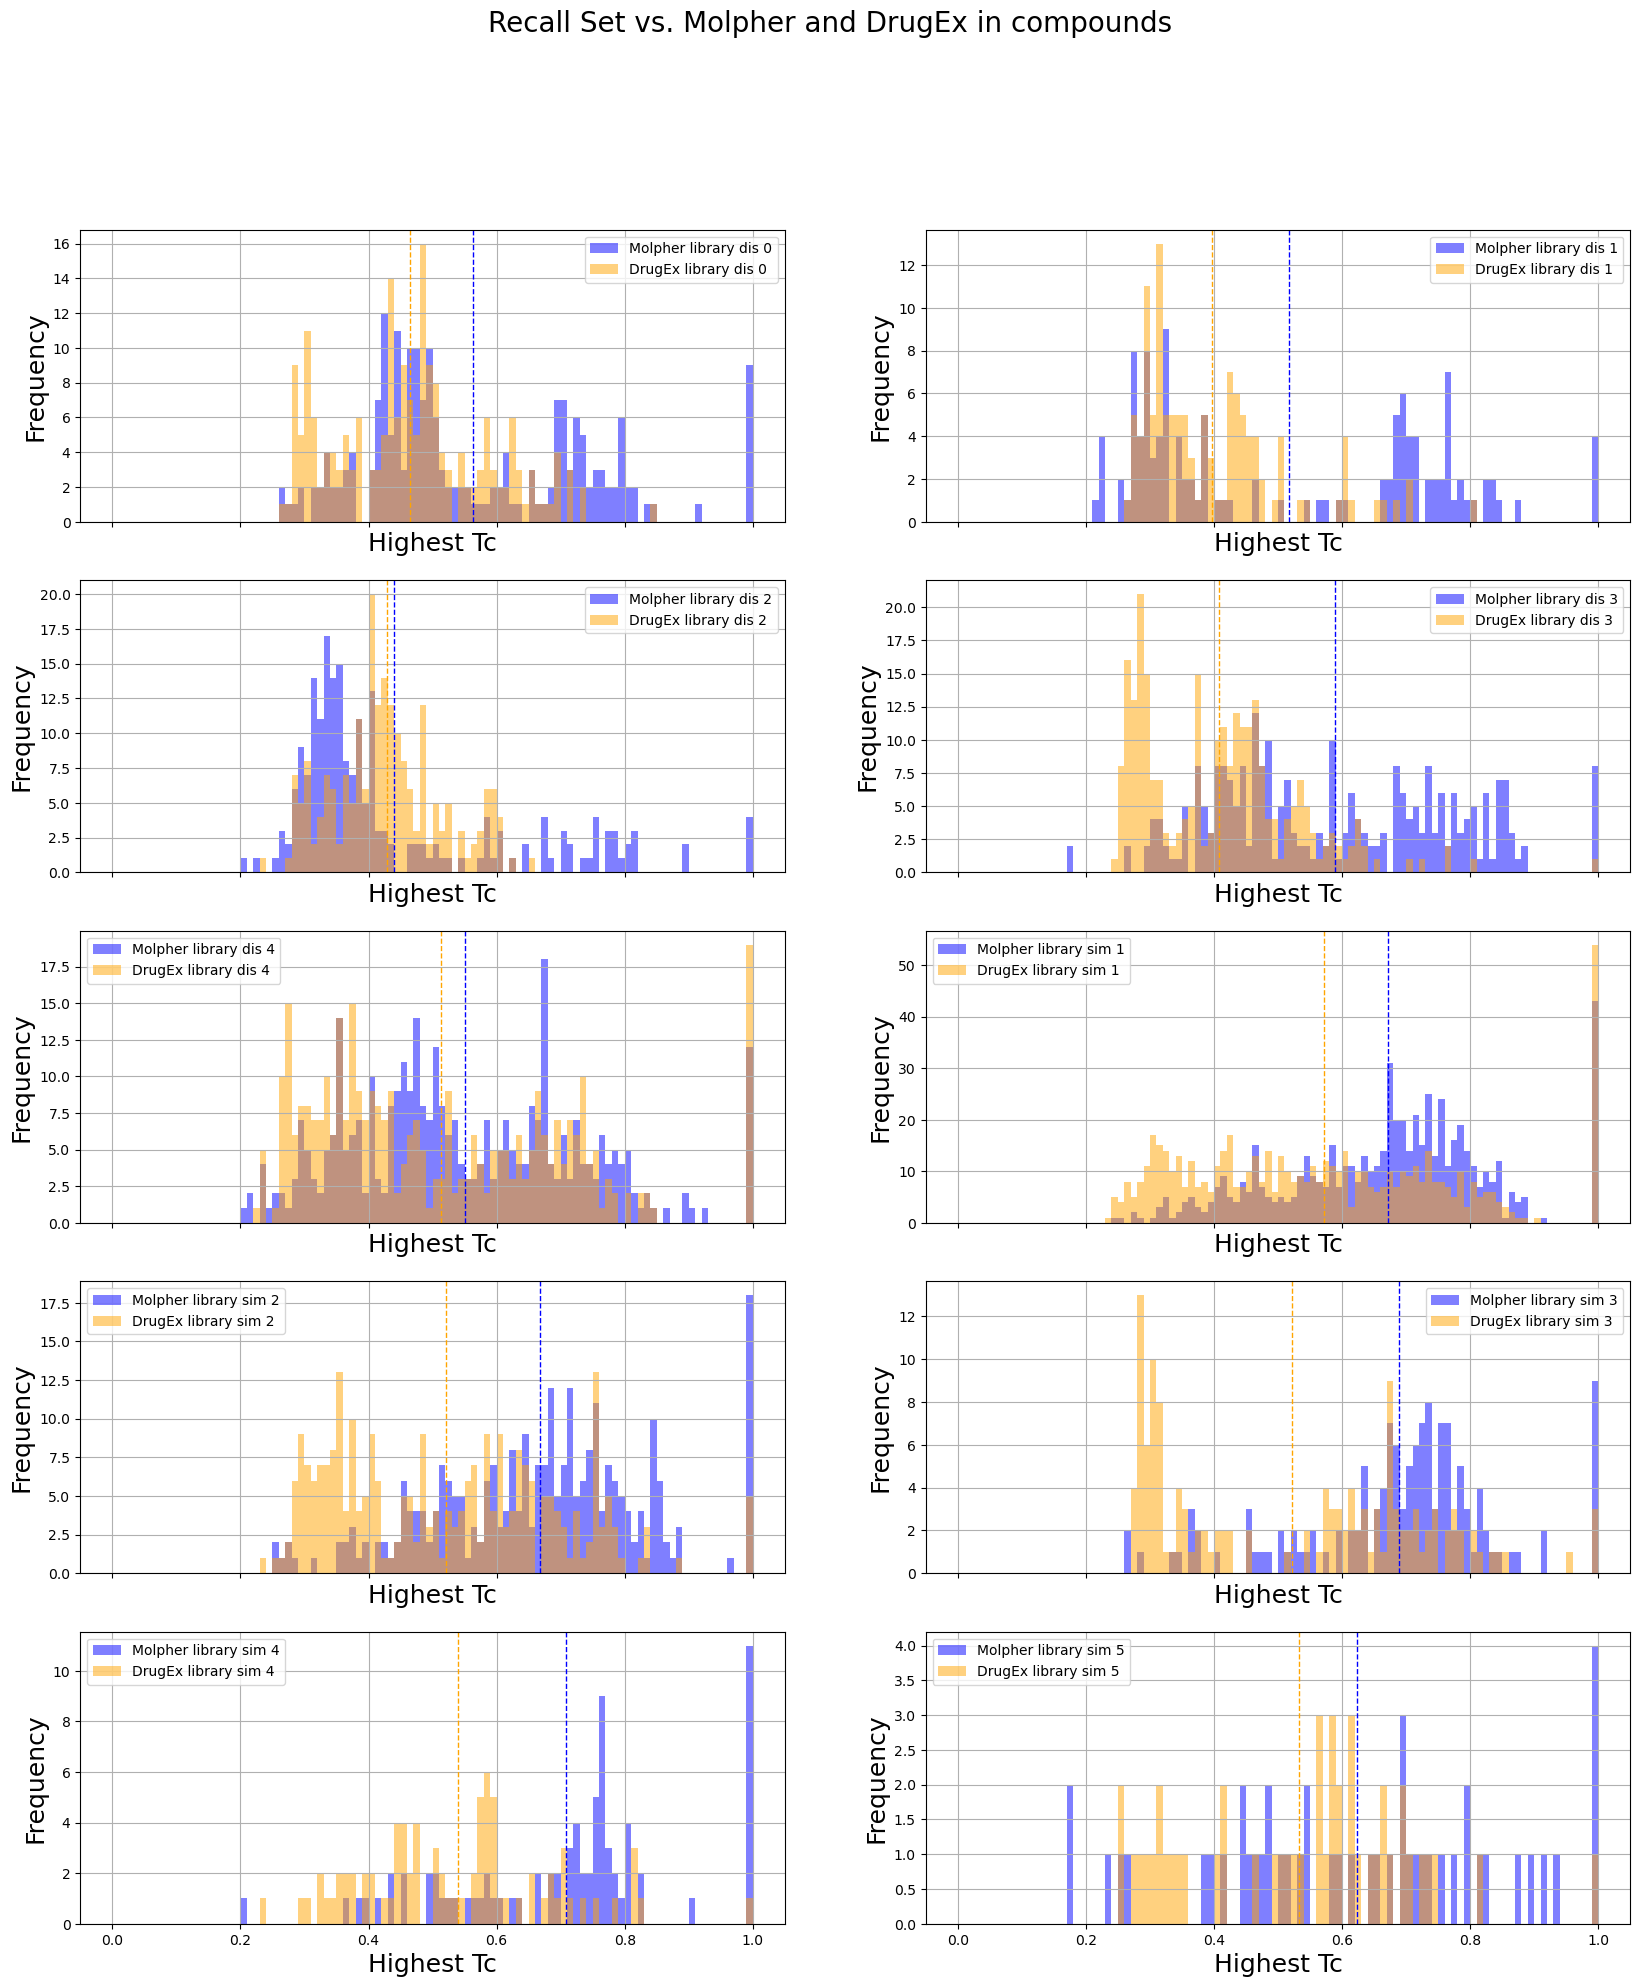

In [46]:
KL_histograms_for_all_10(5, data, 'Recall Set vs. Molpher and DrugEx in compounds')

In [79]:
df = pd.read_csv('data/results/Glucocorticoid_receptor/csk_scaffolds/dis/analysis_compounds/array_with_tc_1_recall_DrugEx_0')
df

Empty DataFrame
Columns: [recall_id, output_id, tc, recall_set, output_set, recall_compound, output_compound]
Index: []

In [81]:
for type in ['dis','sim']:
    for num in range(5):
        df = pd.read_csv(f'data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/analysis_compounds/array_with_tc_1_recall_DrugEx_{num}')
        if not df.empty:
            mols = []
            count = []
            for x in range(len(df)):
                recall = df.loc[x]['recall_set']
                output = df.loc[x]['output_set']
                mols.append(Chem.MolFromSmiles(recall))
                mols.append(Chem.MolFromSmiles(output))
                recall_id = df.loc[x]['recall_id']
                output_id = df.loc[x]['output_id']
                count.append(f'Recall_mol_id:{recall_id}')
                if output_id.count(',') > 2:
                    count.append(f'Output_mol_count:{output_id.count(",") + 1}') 
                else:
                    count.append(f'Output_mol_id:{output_id}') 
                    
            d=Draw.MolsToGridImage(mols,legends = count, molsPerRow=2, subImgSize=(250, 250), returnPNG=False)
            d.save(f"data/results/Glucocorticoid_receptor/csk_scaffolds/{type}/analysis_compounds/compounds_with_tc_1_recall_output_DrugEx_{num}.png")

/home/filv/anaconda3/envs/env/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


In [ ]:
# Get the highest Tanimoto between morphing library and novel set
high_TC_novel_GRML_1 = KL_divergence_prep(novel_data, GRML_filtered, 'canonical_smiles', 'morph_smiles')
high_TC_novel_RML_1 = KL_divergence_prep(novel_data, RML_filtered, 'canonical_smiles', 'morph_smiles')

# Create histograms (probability distributions)
hist1, bin_edges = np.histogram(high_TC_novel_GRML_1, bins=100, range=(0, 1), density=True)
hist2, _ = np.histogram(high_TC_novel_RML_1, bins=100, range=(0, 1), density=True)

# Apply Laplace smoothing
smoothed_hist1 = (hist1 + 1e-10) / np.sum(hist1 + 1e-10)
smoothed_hist2 = (hist2 + 1e-10) / np.sum(hist2 + 1e-10)

# Compute KL divergence
kl_divergence = entropy(smoothed_hist1, smoothed_hist2)

print("KL Divergence:", kl_divergence)